In [ ]:
#-----------------------------------* ENSEMBLE ATTEMPT *---------------------------------------
# Inspider by the paper:Combining Multiple Time Series Models Through A Robust Weighted Mechanism. 
#URL: https://arxiv.org/abs/1302.6595 
# The idea is to combine multiple models, each trained on a specific portion of the dataset, namely one
# of the six domains. The final prediction is obtained by combining the predictions of the single models
# using weighted approach inspired by the paper, which also tries to take into account the correlation
# between the different domains. In this case, rather than explicitly instantiating the weights for the 
# different correlation terms expressed in the paper(in this case, the terms would be more - given there are
# up to 6 domains to take into account rather then 3), we use a simpler approach, with multiple voters, optimized on
# the joint dataset.

# Problem description: develop a forecasting model that is able to predict several uncorrelated time series

# DATA STRUCTURE:
# Single folder containing the following files:
# -> 'training_data.npy': it contains a numpy array of shape (48000, 2776). 48000 time series of length 2776.
# -> 'valid_periods.npy': it contains a numpy array of type (48000, 2) containing for each of the time series the start and end index of the current series, i.e. the part without padding.
# -> 'categories.npy': it contains a numpy array of shape (48000,), containing for each of the time series the code of its category. The possible categories are in {'A', 'B', 'C', 'D', 'E', 'F'}.
# IMPORTANT: This is a dataset consisting of monovariate time series, i.e. composed of a single feature, belonging to six different domains. The time series of each domain are not to be understood as closely related to each other, but only as collected from similar data sources.
# What is required of you is therefore to build a model that is capable of generalising sufficiently to predict the future samples of the 60 time series of the test set.

In [ ]:
# Import libraries and connect to drive personal folder

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/homework_2/Edoardo

# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from keras import backend as K
from keras.callbacks import TensorBoard
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)


# Import other support libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler


Mounted at /gdrive
/gdrive/My Drive/homework_2/Edoardo
2.15.0


In [ ]:
# Define function for data inport:
# The function takes as input the path of the folder containing the data and returns the training data, the validation periods and the categories
# Before doing so, it eventually unzips it if the zip flag is set to True

def import_data(path, zip=False):
    if zip:
        !unzip -q $path
    training_data = np.load('training_data.npy')
    valid_periods = np.load('valid_periods.npy')
    categories = np.load('categories.npy')
    return training_data, valid_periods, categories

# Call the function to import the data
training_data, valid_periods, categories = import_data('training_dataset.zip', zip=False)

# Check the shape of the data
print(training_data.shape)
print(valid_periods.shape)
print(categories.shape)

#Define fullyconnected flag : it determines wheter the ensemble will be made out of single LSTM + Conv1D models
# or Fully connected dense Networks
fully_connected = True
# Transform the data by extending the dimensions (number of time series, length of time series, number of features)
if not fully_connected :
  training_data = np.expand_dims(training_data, axis=2)


(48000, 2776)
(48000, 2)
(48000,)


Text(0.5, 0.98, 'First 10 time series without padding')

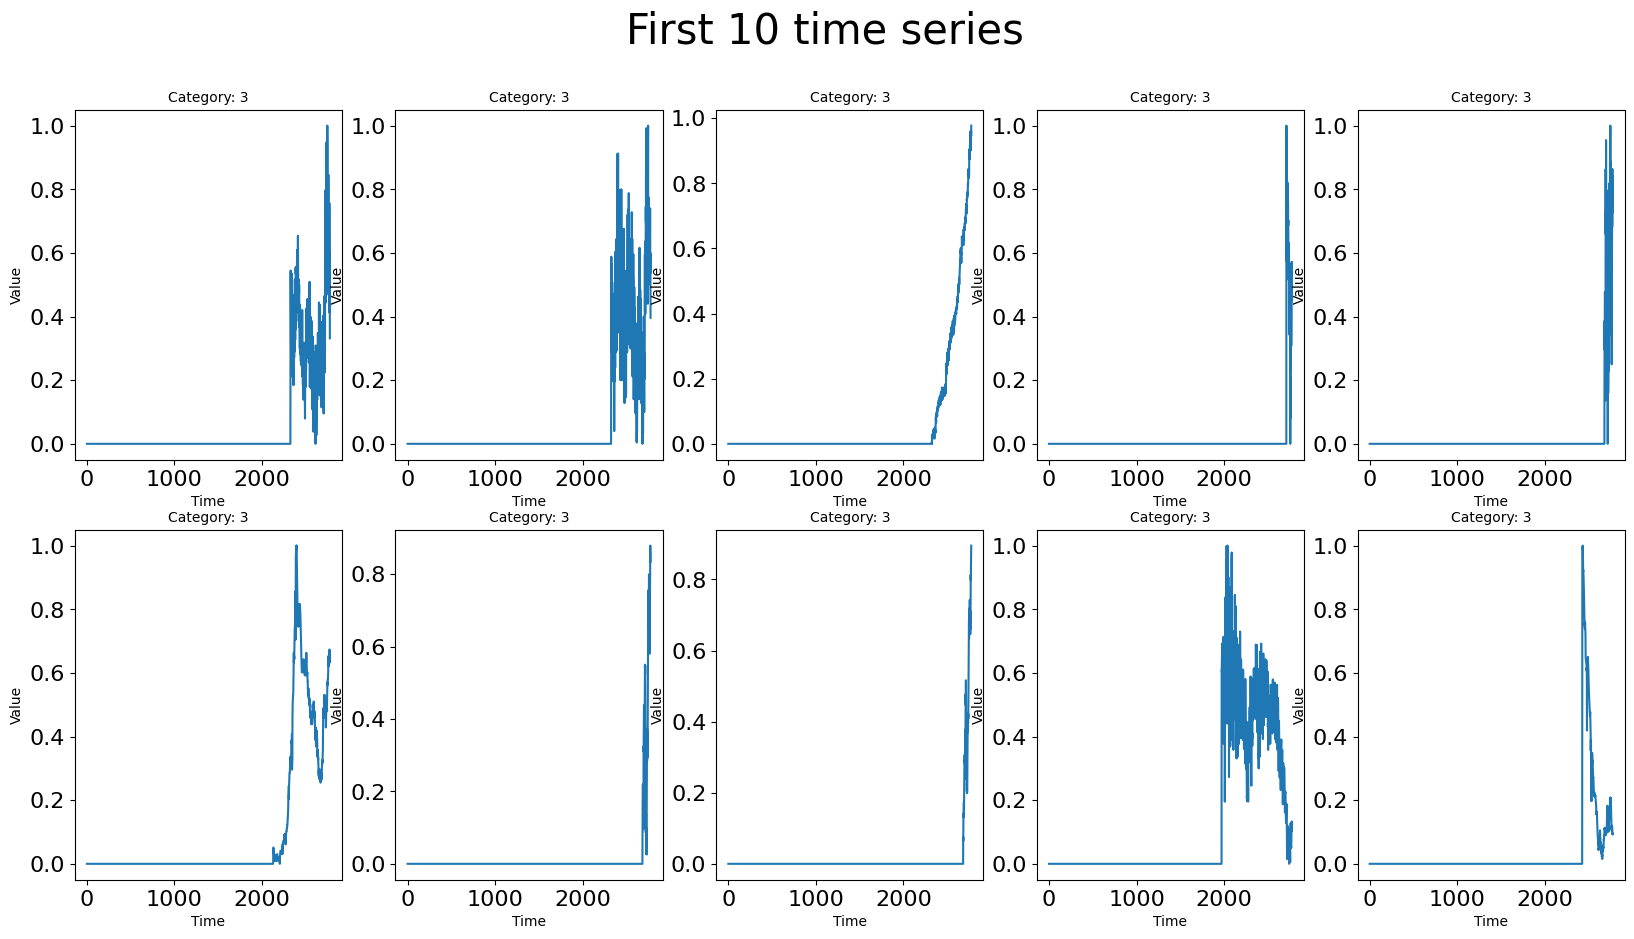

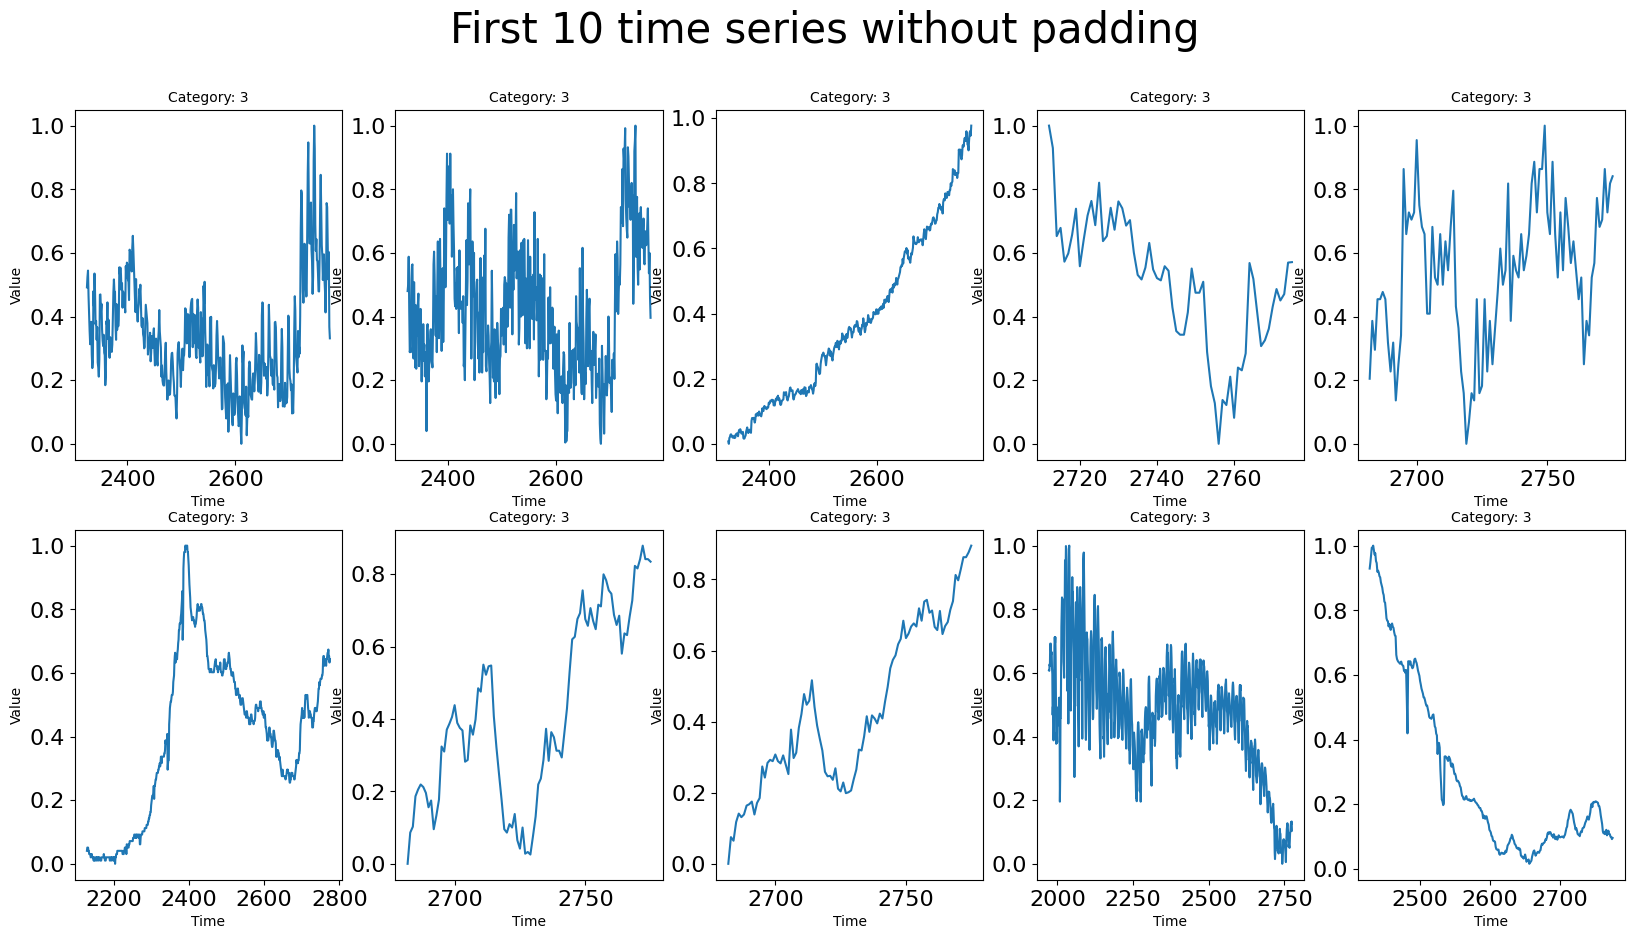

In [ ]:
# -----------------------------------* DATA ANALYSIS *---------------------------------------

# Note that all the values are store as float64, so we can convert them to float32 to save memory
if training_data.dtype == np.float64:
    training_data = training_data.astype(np.float32)


# Transform the categories into numbers
categorical_to_numerical = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F':5}

if categories[0] == "D":
    for category in np.unique(categories):
        categories[categories == category] = categorical_to_numerical[category]
    # To save memory, convert the categories to int32
    categories = categories.astype(np.int32)

# -<-<-<-<-<-<-<-<-<-< FIRST PLOTS AND PADDING REMOVAL/NORMALIZATION >->->->->->->->->->->-

# Plot the first 10 time series

fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.ravel()
for i in range(10):
    axs[i].plot(training_data[i])
    axs[i].set_title('Category: {}'.format(categories[i]), fontsize=10)
    axs[i].set_xlabel('Time', fontsize=10)
    axs[i].set_ylabel('Value', fontsize=10)

fig.suptitle('First 10 time series', fontsize=30)

# -<-<-<-<-<-<-<-<-<-<-<-< DATA NORMLIZATION >->->->->->->->->->->->->-
# AS THE DATA HAS ALREADY BEEN NORMALIZED (EACH ROW HAS BEEN NORMALIZED INDIPENDENTLY)
# WE DEEMED THIS STEP NOT NECESSARY


# Define min_max normalization function
def min_max_norm(data, min, max):
    return (data - min) / (max - min)

# Apply the function over the categories singularly
def min_max_norm_by_category(data, categories):
    # Loop over the categories
    for category in np.unique(categories):
        # For each category compute the min and max
        C_min = np.min(data[categories == category])
        C_max = np.max(data[categories == category])
        # Apply the min_max_norm function to the data of the current category
        data[categories == category] = min_max_norm(data[categories == category], C_min, C_max)
    return data

# Function to apply a custom implementation of a robust scaler:
# the function takes as input the non-padded data (so a list of time series with different lenghts)
# and, based on their category, compute the median and the interquartile range (IQR) based on the value
# argument, and then apply the robust scaler normalization to the data of the current category
# returning a copy of the normalized data
def robust_scaler_normalization(data, categories = None, value = 10):
    #Compute median value over list of arrays of different lenghts
    def median(data):
        return np.median(np.concatenate(data))
    #Compute IQR value over list of arrays of different lenghts
    def IQR(data):
        return np.subtract(*np.percentile(np.concatenate(data), [75, 25]))
    # Compute the median and IQR for each category
    if categories is None:
        C_median = median(data)
        C_IQR = IQR(data)
        data = (data - C_median) /  C_IQR
    else:
        C_median = []
        C_IQR = []
        for category in np.unique(categories):
            C_median.append(median(data[categories == category]))
            C_IQR.append(IQR(data[categories == category]))
            data[categories == category] = (data[categories == category] - C_median[category]) /  C_IQR[category]
    return data



# -<-<-<-<-<-<-<-<-<-<  PADDING REMOVAL >->->->->->->->->->-
# Define a function to remove the padding from the time series

def remove_padding(data, valid_periods):
    data_no_pad = []
    for i in range(data.shape[0]):
        data_no_pad.append(data[i, valid_periods[i, 0]:valid_periods[i, 1]])
    return np.array(data_no_pad)


# Remove the padding from the time series
training_data_no_pad = remove_padding(training_data, valid_periods)

# Call the function for robust scaler normalization
#training_data_no_pad = robust_scaler_normalization(training_data_no_pad, categories)

# Call the functino for min-max scaling
#training_data_no_par = min_max_norm_by_category(training_data_no_pad,categories)

# Plot the first 10 time series without padding, keeping the information about the orignal temporal location
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.ravel()
for i in range(10):
    axs[i].plot(range(valid_periods[i, 0], valid_periods[i, 1]), training_data_no_pad[i])
    axs[i].set_title('Category: {}'.format(categories[i]), fontsize=10)
    axs[i].set_xlabel('Time', fontsize=10)
    axs[i].set_ylabel('Value', fontsize=10)

fig.suptitle('First 10 time series without padding', fontsize=30)

# All this samples belong to category D, and are "to be understood as not closely related to each other, but only as collected from similar data sources"
# This means that the time seies within the same categoty are to be considered as uncorrelated, but should there not be a correlationbetween the catoegories?


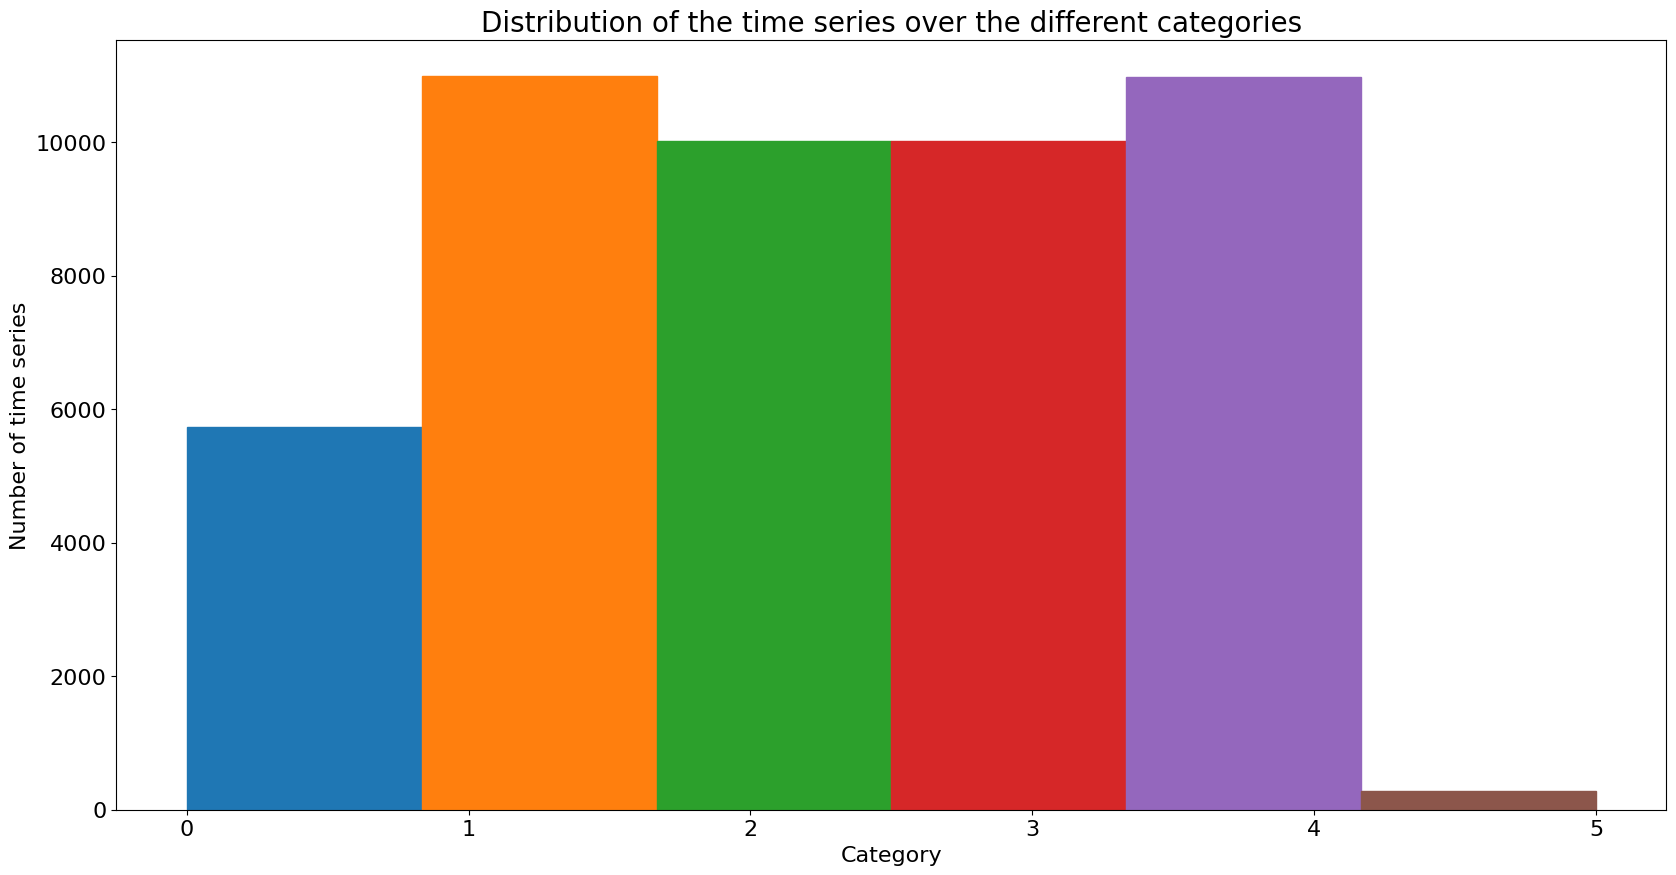

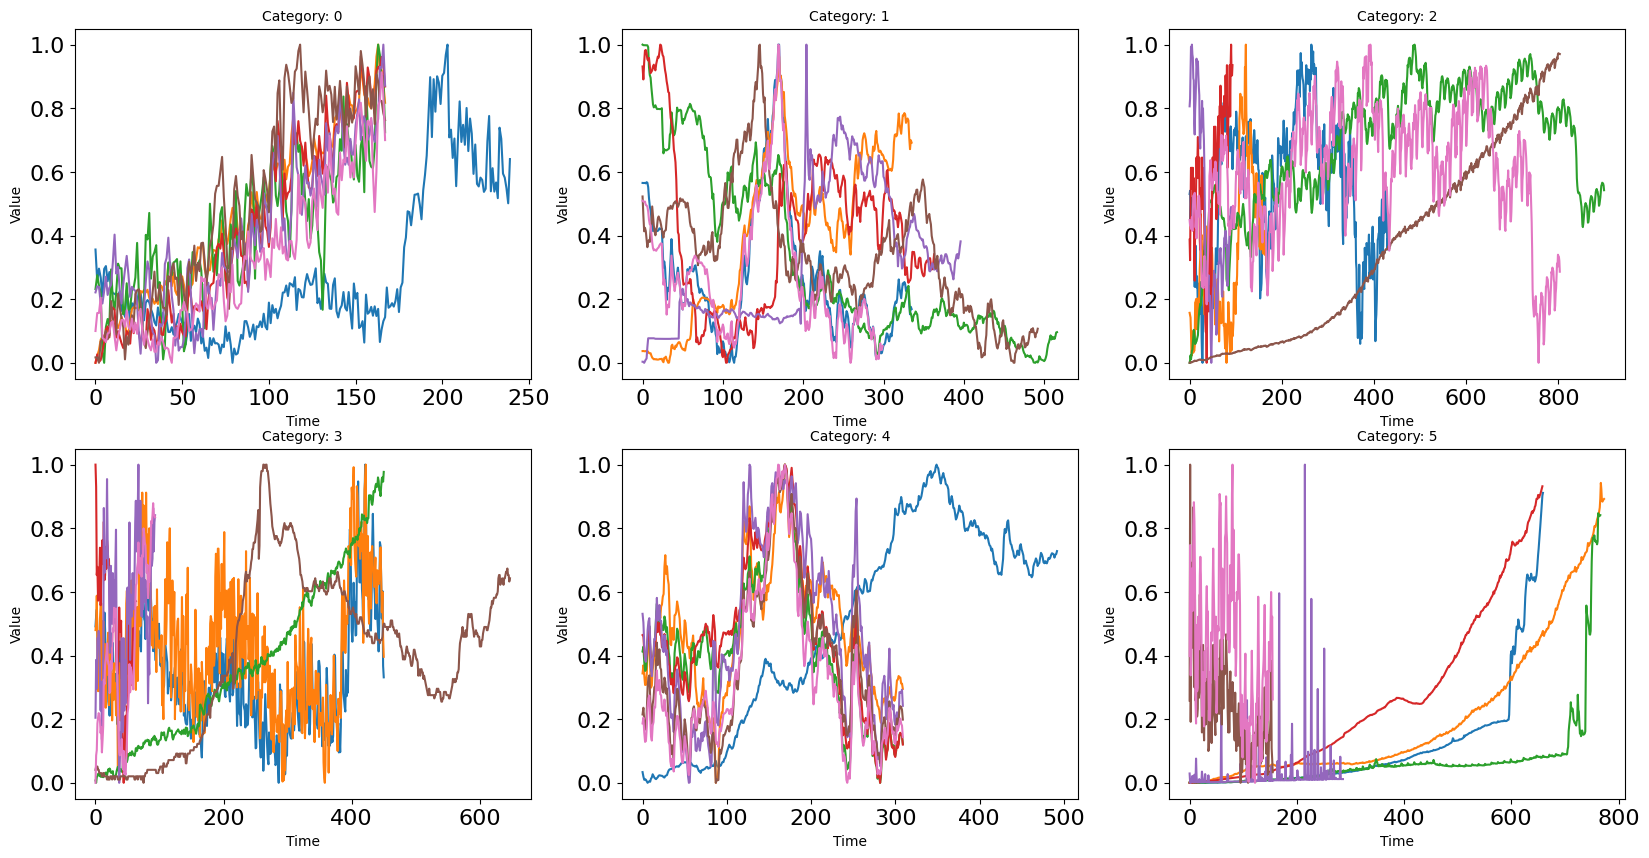

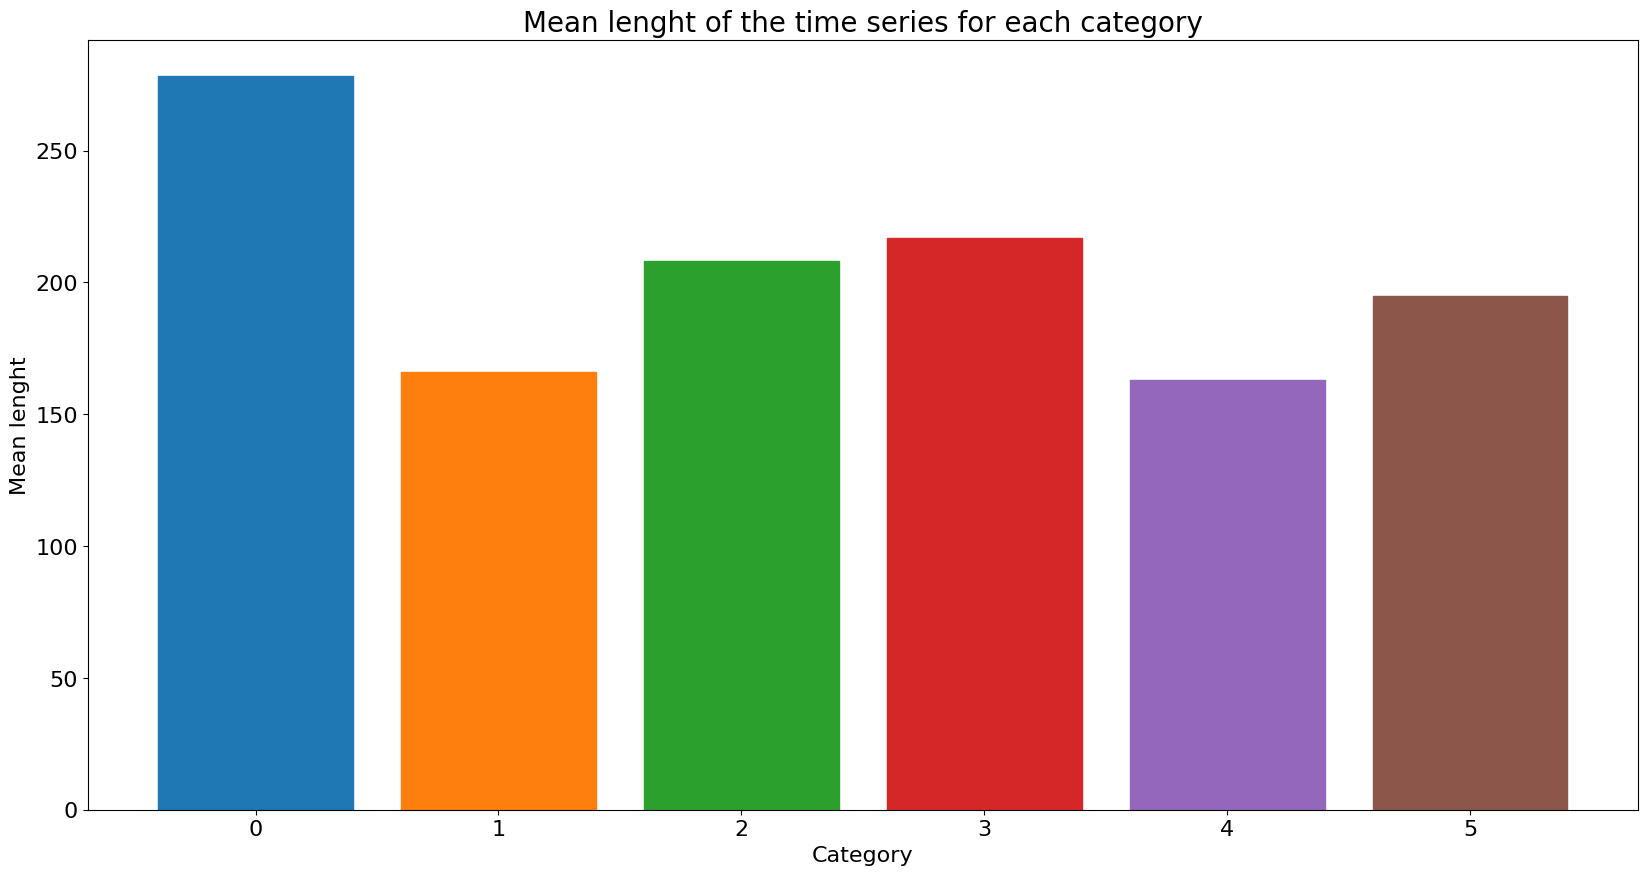

In [ ]:

# -<-<-<-<-<-<-<-<-<-< DATA DISTRIBUTION ANALYSIS >->->->->->->->->->->-


# GROUP DATA BY CATEGORY:

# Now plot the distribution of the time series over the different categories
fig, ax = plt.subplots(figsize=(20, 10))
ax.hist(categories, bins=6)
ax.set_title('Distribution of the time series over the different categories', fontsize=20)
ax.set_xlabel('Category')
ax.set_ylabel('Number of time series')
# separate the bars and use different colors
for i in range(6):
    ax.patches[i].set_color('C{}'.format(i))
plt.xticks(np.arange(6))

# OSS: a visible imbalance between the categories is present, with category 5 been extremely underrepresented
# (category 1 is just slightly underrepresented, while the other categories are more or less equally represented)


# -<-<-<-<-<-<-< PLOT OF FIRST TIME SERIES FOR DIFFERENT CATEGORIES >->->->->->-
# Plot the first n time series for each category (6 diffrerent plots, with multiple time series in each plot)
n = 7
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.ravel()
for i in range(6):
    for j in range(n):
      axs[i].plot(training_data_no_pad[categories == i][j])
    axs[i].set_title('Category: {}'.format(i), fontsize=10)
    axs[i].set_xlabel('Time', fontsize=10)
    axs[i].set_ylabel('Value', fontsize=10)
# -<-<-<-<-<-<-< PLOT OF TIME SERIES BY LENGHT AND DOMAIN  >->->->->->-

# Compute mean lenght of the time series for each category and plot them in a bar plot
mean_lenght = []
for i in range(6):
    mean_lenght.append(np.mean(valid_periods[categories == i, 1] - valid_periods[categories == i, 0]))
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(np.arange(6), mean_lenght)
ax.set_title('Mean lenght of the time series for each category', fontsize=20)
ax.set_xlabel('Category')
ax.set_ylabel('Mean lenght')
plt.xticks(np.arange(6))
for i in range(6):
    ax.patches[i].set_color('C{}'.format(i))

# OSS: a fairly similar mean lenght for all the categories




In [ ]:
# Define some Hyperparameters for the forcasting model
WINDOW_SIZE = 200
BATCH_SIZE = [256, 256, 256, 256, 256, 32]
STRIDE = 10
EPOCHS = [90, 100, 90, 90, 90, 100]
DELTA_MIN = [0.00007, 0.00001, 0.00007, 0.00007, 0.00007, 0.00001]
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.03
TELESCOPE = 18
AUTOREGRESSIVE_TELESCOPE = 3
assert AUTOREGRESSIVE_TELESCOPE < TELESCOPE

# In this case, given the nature of the problem, as well as the fact that the time series are not correlated
# (so introducing some of them in training phase should now bias the test), we decide
# to make use of the great variaty of time series available, and split data among the time series themselves:

# This way, a certain percentage of the time series will be used for training (80% initial partition), while the remaining ones will be used for validation (20).
# In both case, we define the number of samples to be predicted as TELESCOPE, and the number of samples to be used for the prediction as WINDOW_SIZE.

# For the testing, we respect the imbalances among the different domains using stratify based on the categories

X_train_raw, X_test_raw, domains_train, domains_test = train_test_split(training_data_no_pad, categories, test_size=TEST_SPLIT, stratify=categories)
X_train_raw, X_val_raw, domains_train, domains_val = train_test_split(X_train_raw, domains_train, test_size=VALIDATION_SPLIT, stratify=domains_train)

In [ ]:
# -----------------------------------* DATA PREPROCESSING *---------------------------------------
# Build the sequences for the forecasting model: in this case, we will try to take into account the
# imbalance between the categories usign a weighted loss function

# The function lets us build the sequences to use for the training of the forecasting model:
# In this case, given a certain domain (category), the function will build the sequences to be used for the training
# by extracting temporal windows out of each time series.
def build_sequences_on_domain(data, categories_split  ,domain = 0, window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = data[categories_split == domain]
    temp_label = temp_df.copy()
    # For each time series of the specific domain, compute the padding lenght
    # OSS... This is done on the data without padding
    for time_series_n in range(len(temp_df)):
        padding_len = (window + telescope) - len(temp_df[time_series_n])
        if(padding_len > 0):
            if fully_connected:
              padding = np.zeros((padding_len), dtype='float32')
            else:
              padding = np.zeros((padding_len,1), dtype='float32')
            temp_df[time_series_n] = np.concatenate((padding,temp_df[time_series_n]))
            temp_label[time_series_n] = np.concatenate((padding,temp_label[time_series_n]))


    for time_series_n in range(len(temp_df)):
          for i in np.arange(0, len(temp_df[time_series_n])-window-telescope, stride):
              dataset.append(temp_df[time_series_n][i:i+window])
              labels.append(temp_label[time_series_n][i+window:i+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

def inspect_multivariate(X, y, telescope, idx=None, data_to_plot= 5):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    # Plot three sequences chosen based on idx
    figs, axs = plt.subplots(data_to_plot, 1, sharex=True, figsize=(30,15))
    for i in range(idx, idx+data_to_plot):
        axs[i-idx].plot(np.arange(len(X[i])), X[i])
        axs[i-idx].scatter(np.arange(len(X[i]), len(X[i])+telescope), y[i], color='orange')
        axs[i-idx].set_title('Sequence {}'.format(i))
        axs[i-idx].set_ylim(0,1)
    plt.show()


def inspect_multivariate_prediction(X, y, pred, telescope, idx=None, data_to_plot= 5):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    # Plot data_to_plot sequences chosen based on idx
    figs, axs = plt.subplots(data_to_plot, 1, sharex=True, figsize=(30,15))
    for i in range(idx, idx+data_to_plot):
        axs[i-idx].plot(np.arange(len(X[i])), X[i])
        axs[i-idx].scatter(np.arange(len(X[i]), len(X[i])+telescope), y[i], color='orange')
        axs[i-idx].scatter(np.arange(len(X[i]), len(X[i])+telescope), pred[i], color='green')
        axs[i-idx].set_title('Sequence {}'.format(i))
        axs[i-idx].set_ylim(0,1)
    plt.show()

In [ ]:

# Build the different datasets for the different domains

X_train = []
y_train = []
for domain in range(6):
    temp_X, temp_y = build_sequences_on_domain(data=X_train_raw,categories_split=domains_train, domain = domain, window=WINDOW_SIZE, stride=STRIDE, telescope=AUTOREGRESSIVE_TELESCOPE)
    X_train.append(temp_X)
    y_train.append(temp_y)


X_val = []
y_val = []
for domain in range(6):
    temp_X, temp_y = build_sequences_on_domain(data=X_val_raw,categories_split=domains_val, domain = domain, window=WINDOW_SIZE, stride=STRIDE, telescope=AUTOREGRESSIVE_TELESCOPE)
    X_val.append(temp_X)
    y_val.append(temp_y)

X_test_reg , y_test_reg = build_sequences_on_domain(data=X_test_raw,categories_split=domains_test, domain = 0, window=WINDOW_SIZE, stride=STRIDE, telescope=TELESCOPE)
for domain in range(1,6):
    temp_X, temp_y = build_sequences_on_domain(data=X_test_raw,categories_split=domains_test, domain = domain, window=WINDOW_SIZE, stride=STRIDE, telescope=TELESCOPE)
    print(temp_X.shape)
    X_test_reg = np.concatenate((X_test_reg, temp_X))
    y_test_reg = np.concatenate((y_test_reg, temp_y))


# Print some shapes to check the correctness of the procedure
print('--> Training set:')
for i in range(6):
    print('Domain {}:'.format(i))
    print(X_train[i].shape)
    print(y_train[i].shape)
print('--> Validation set:')
for i in range(6):
    print('Domain {}:'.format(i))
    print(X_val[i].shape)
    print(y_val[i].shape)
print('--> Test set:')
print(X_test_reg.shape)
print(y_test_reg.shape)



(808, 200)
(1873, 200)
(1846, 200)
(1231, 200)
(25, 200)
--> Training set:
Domain 0:
(39613, 200)
(39613, 3)
Domain 1:
(26743, 200)
(26743, 3)
Domain 2:
(42878, 200)
(42878, 3)
Domain 3:
(53276, 200)
(53276, 3)
Domain 4:
(34346, 200)
(34346, 3)
Domain 5:
(1063, 200)
(1063, 3)
--> Validation set:
Domain 0:
(10422, 200)
(10422, 3)
Domain 1:
(6627, 200)
(6627, 3)
Domain 2:
(10229, 200)
(10229, 3)
Domain 3:
(14641, 200)
(14641, 3)
Domain 4:
(8544, 200)
(8544, 3)
Domain 5:
(304, 200)
(304, 3)
--> Test set:
(7359, 200)
(7359, 18)


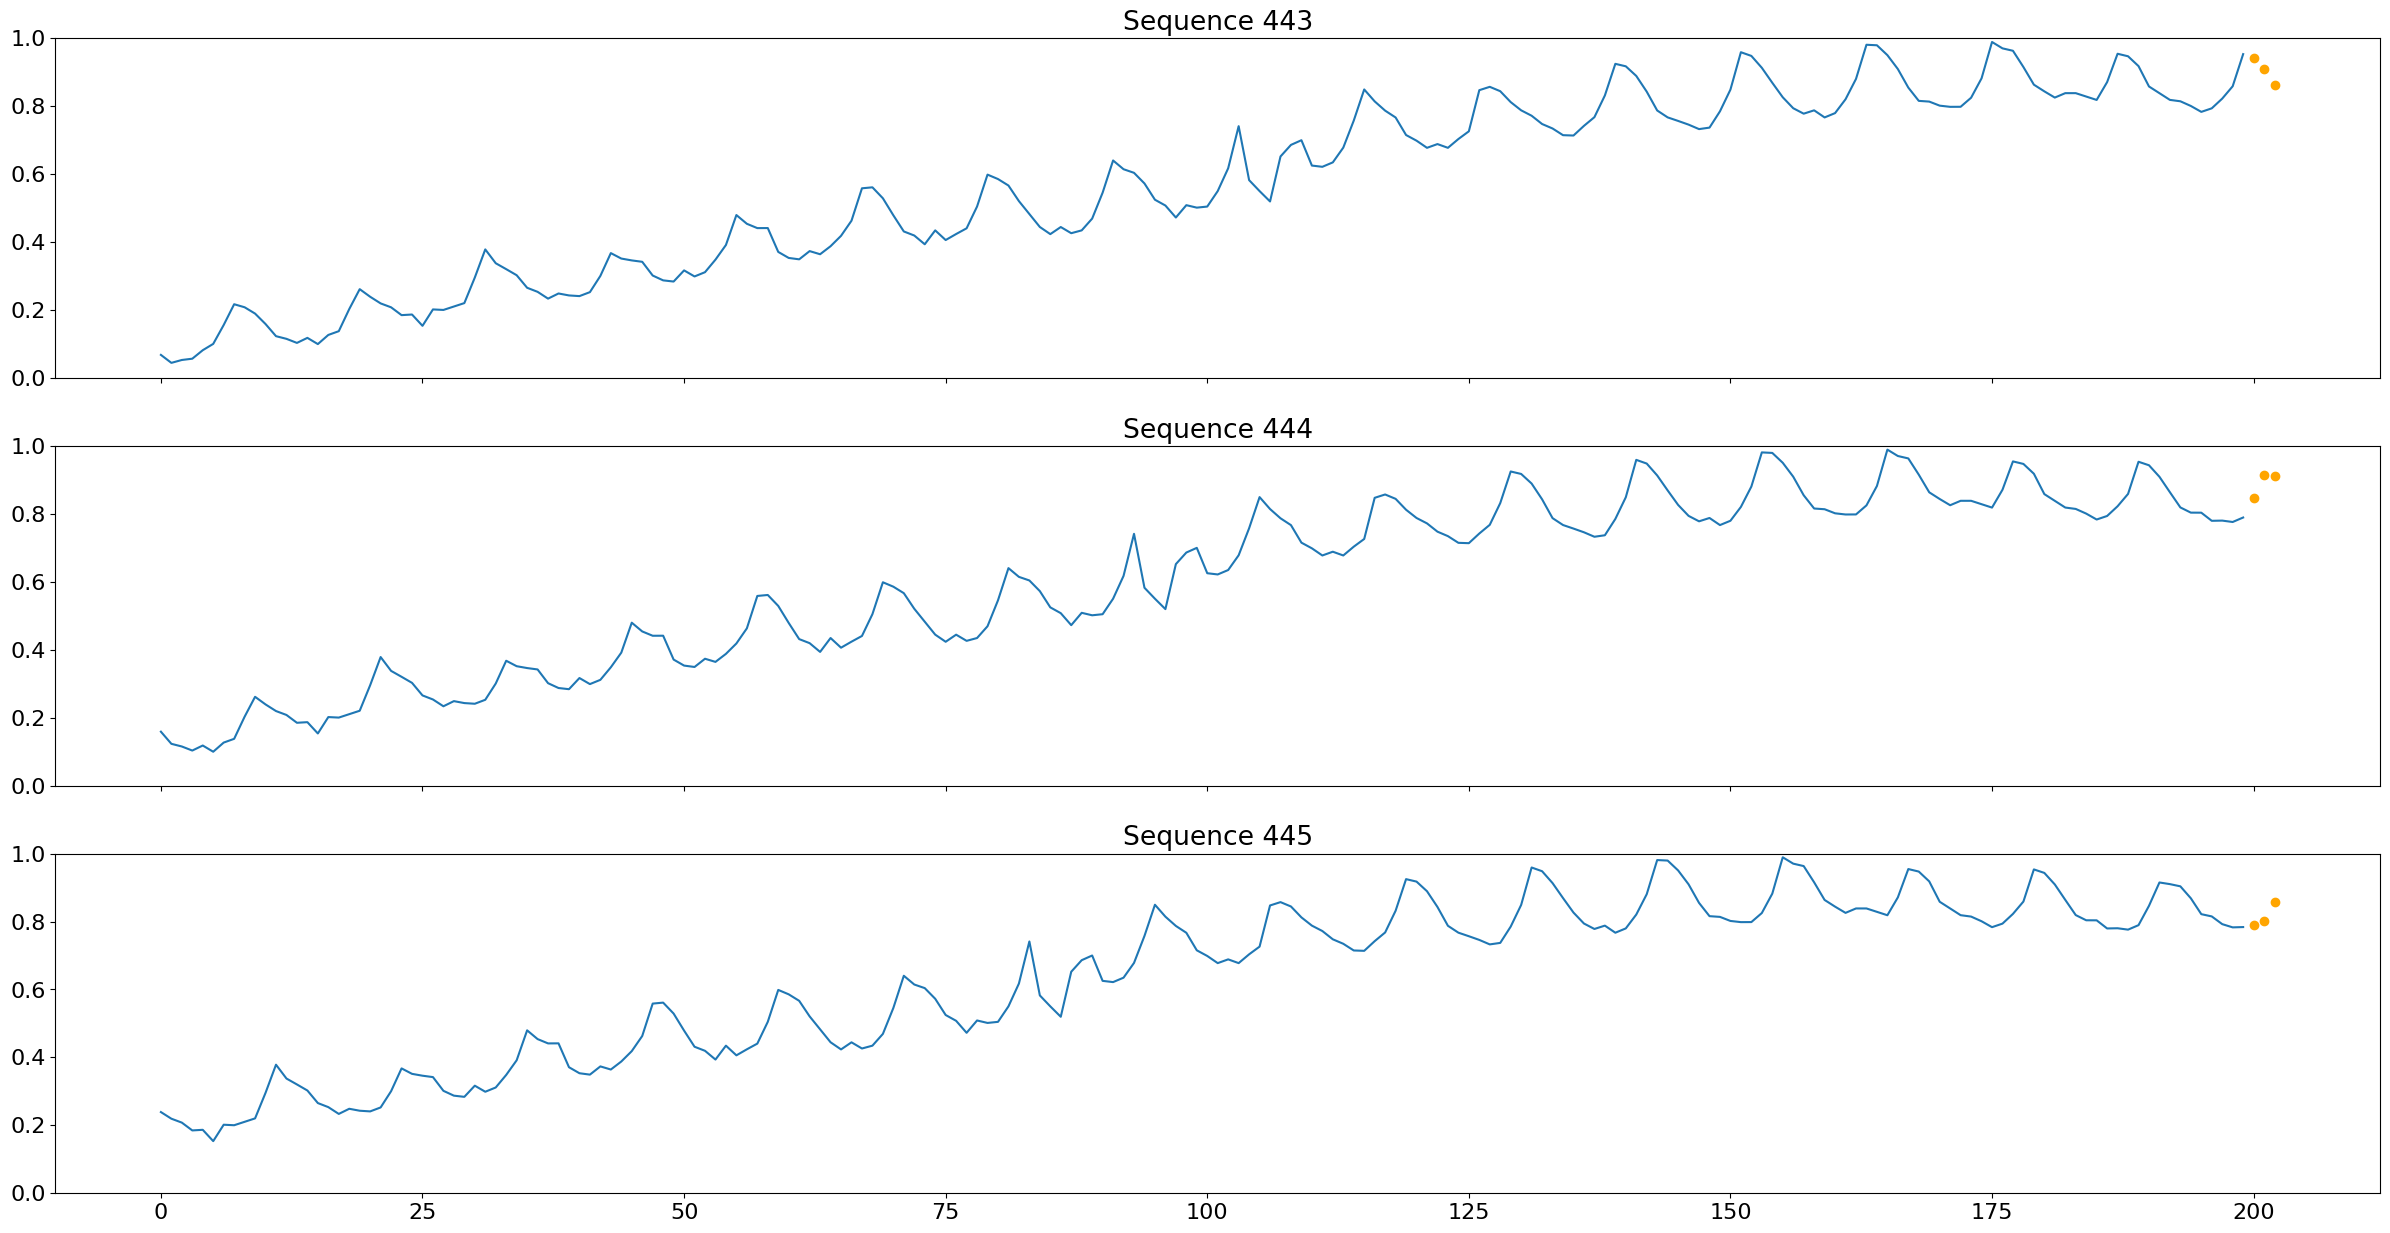

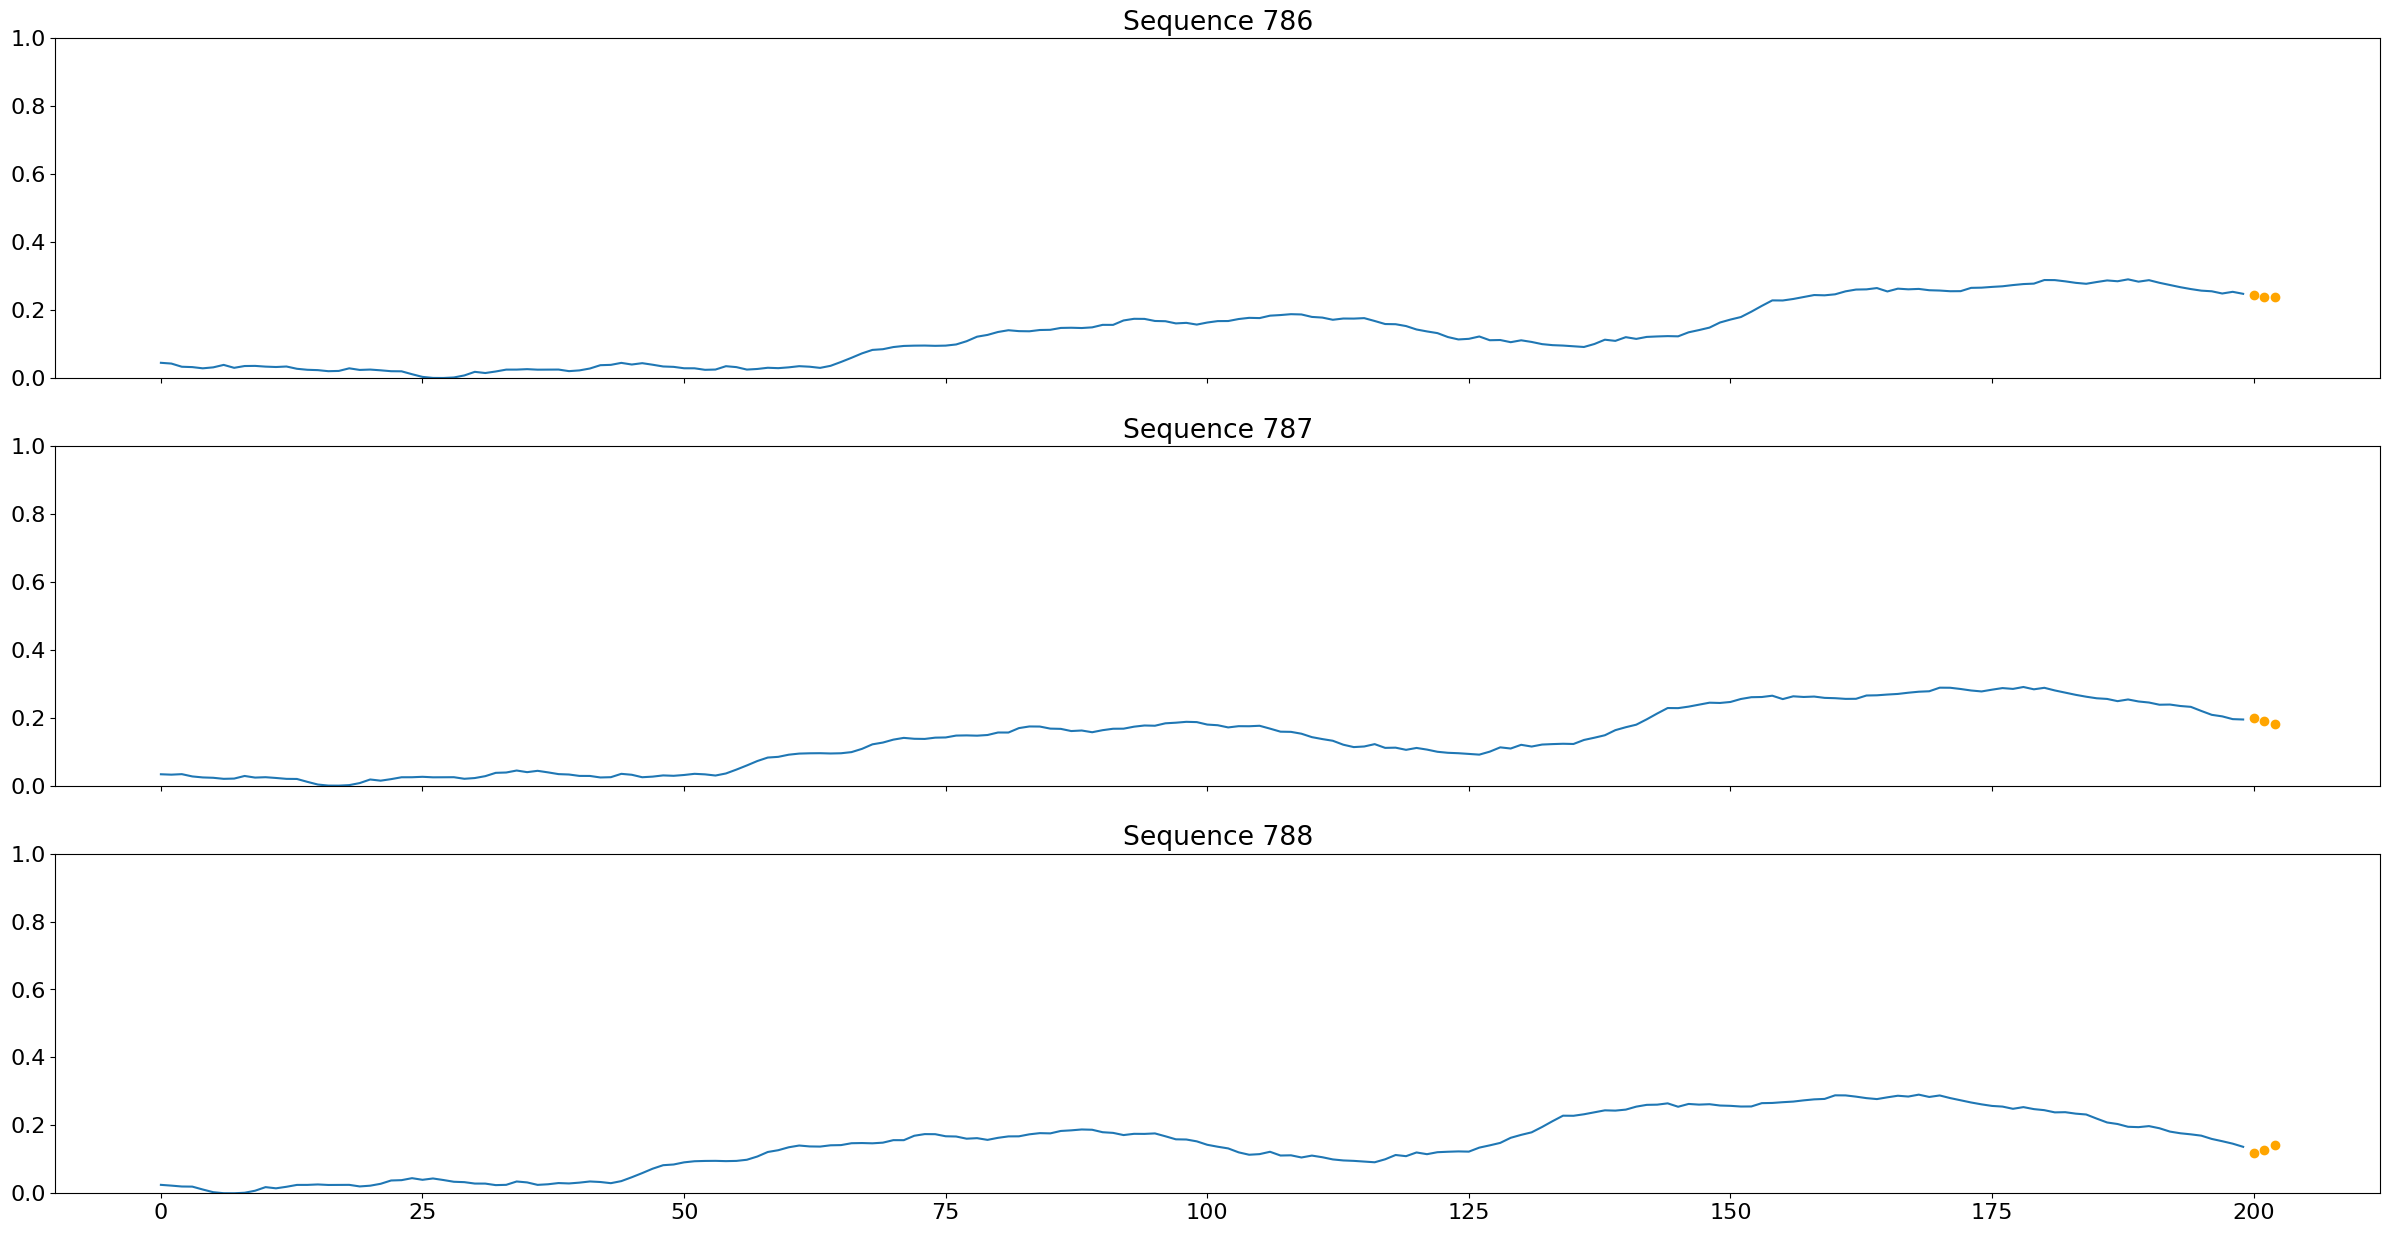

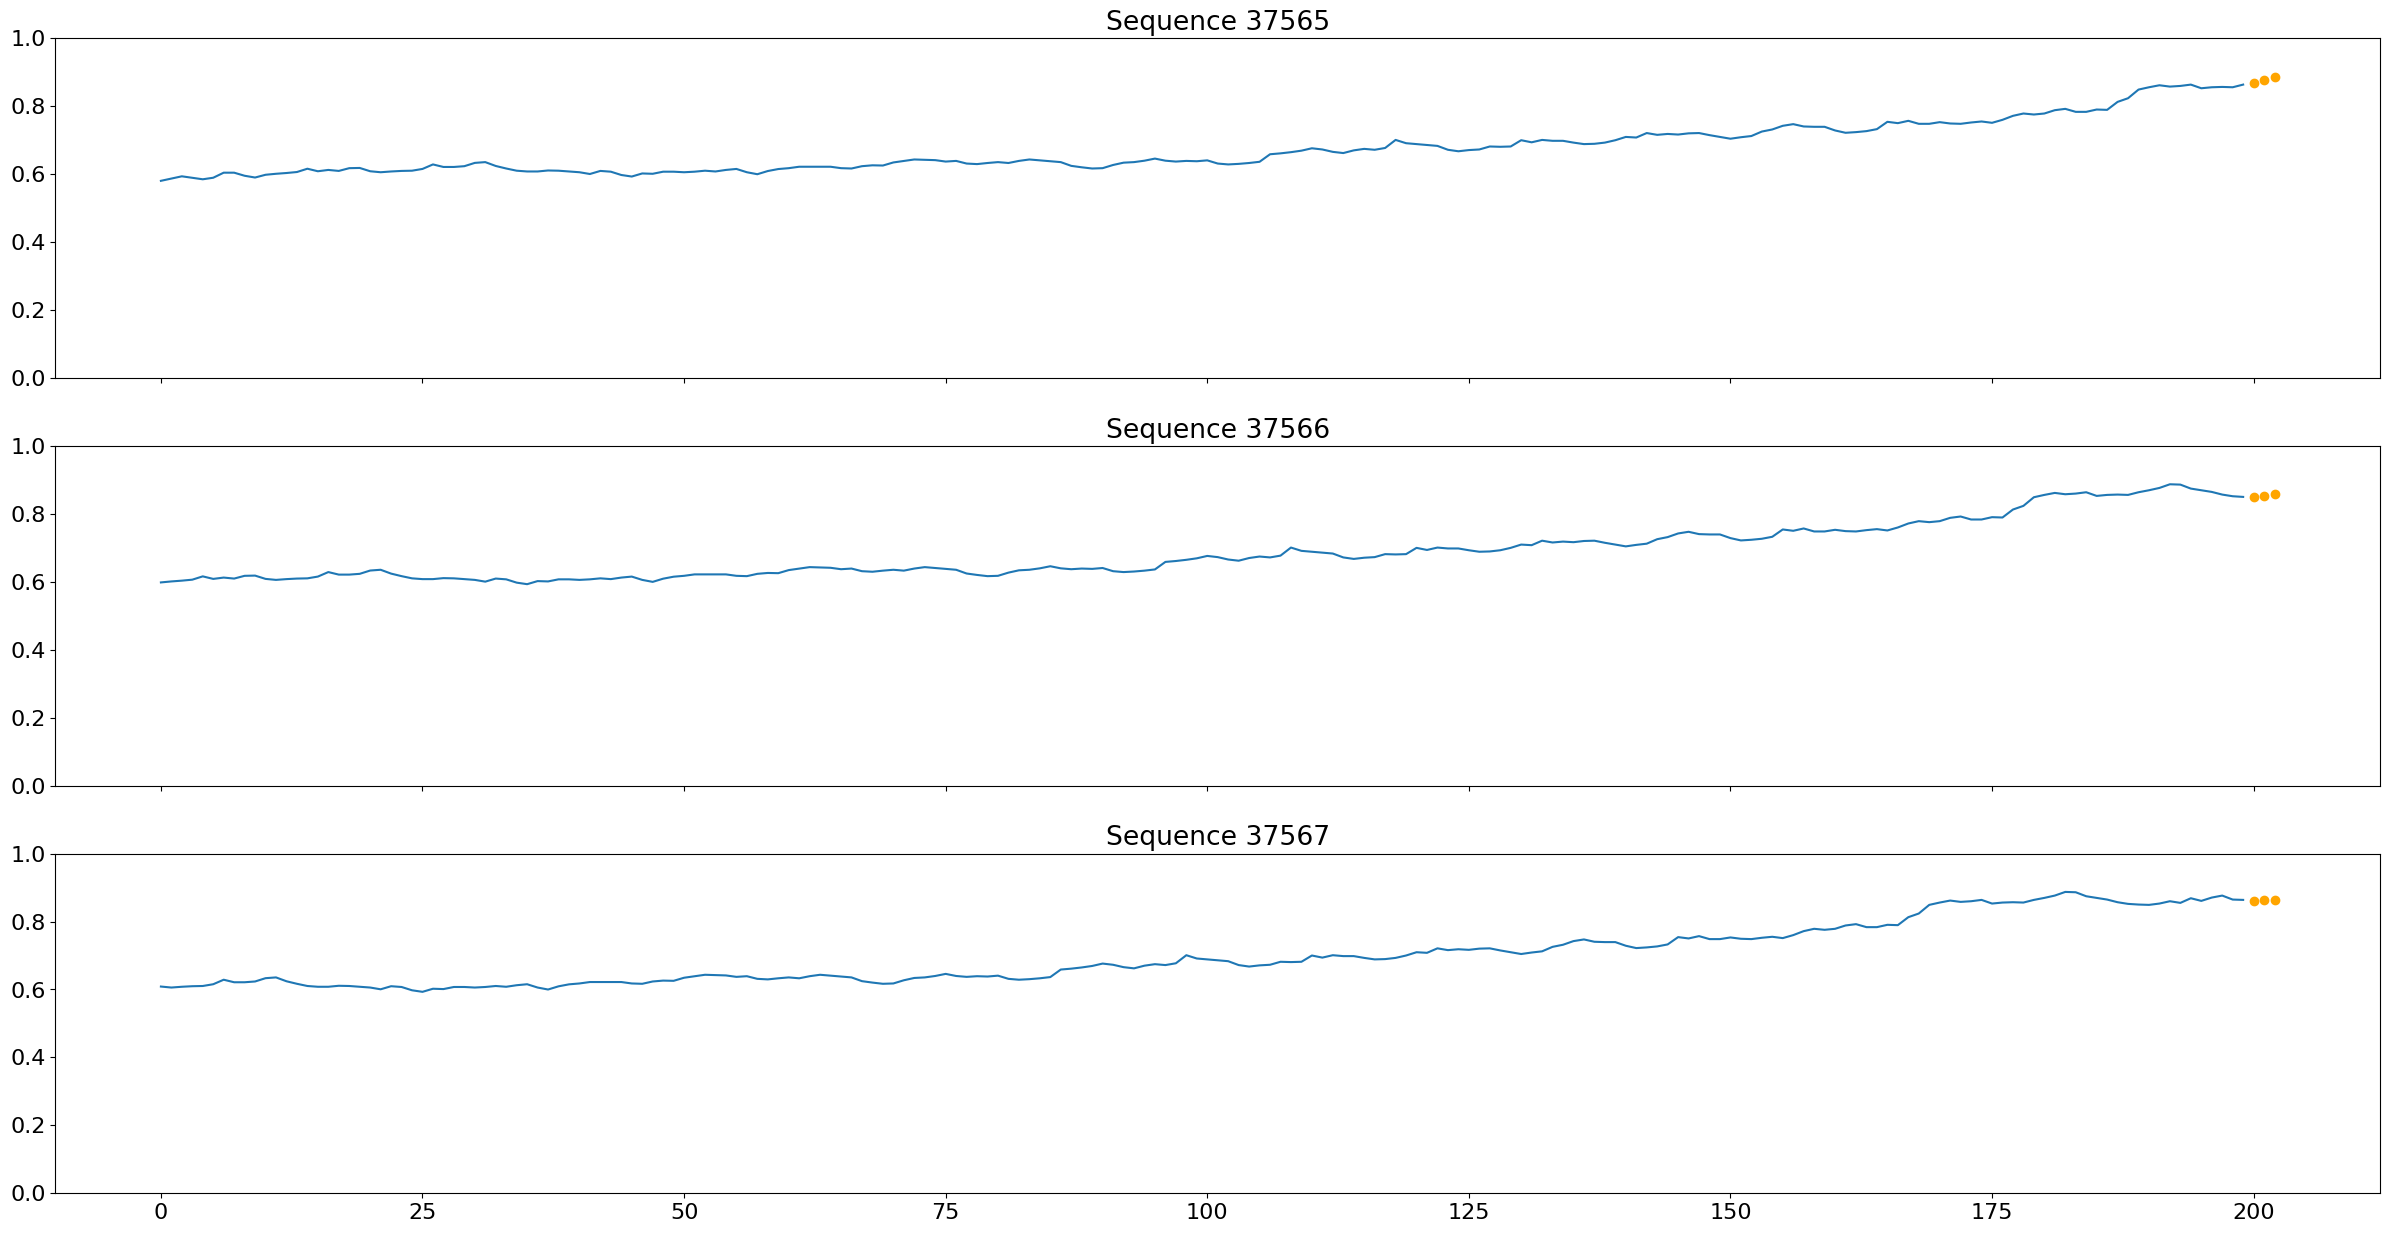

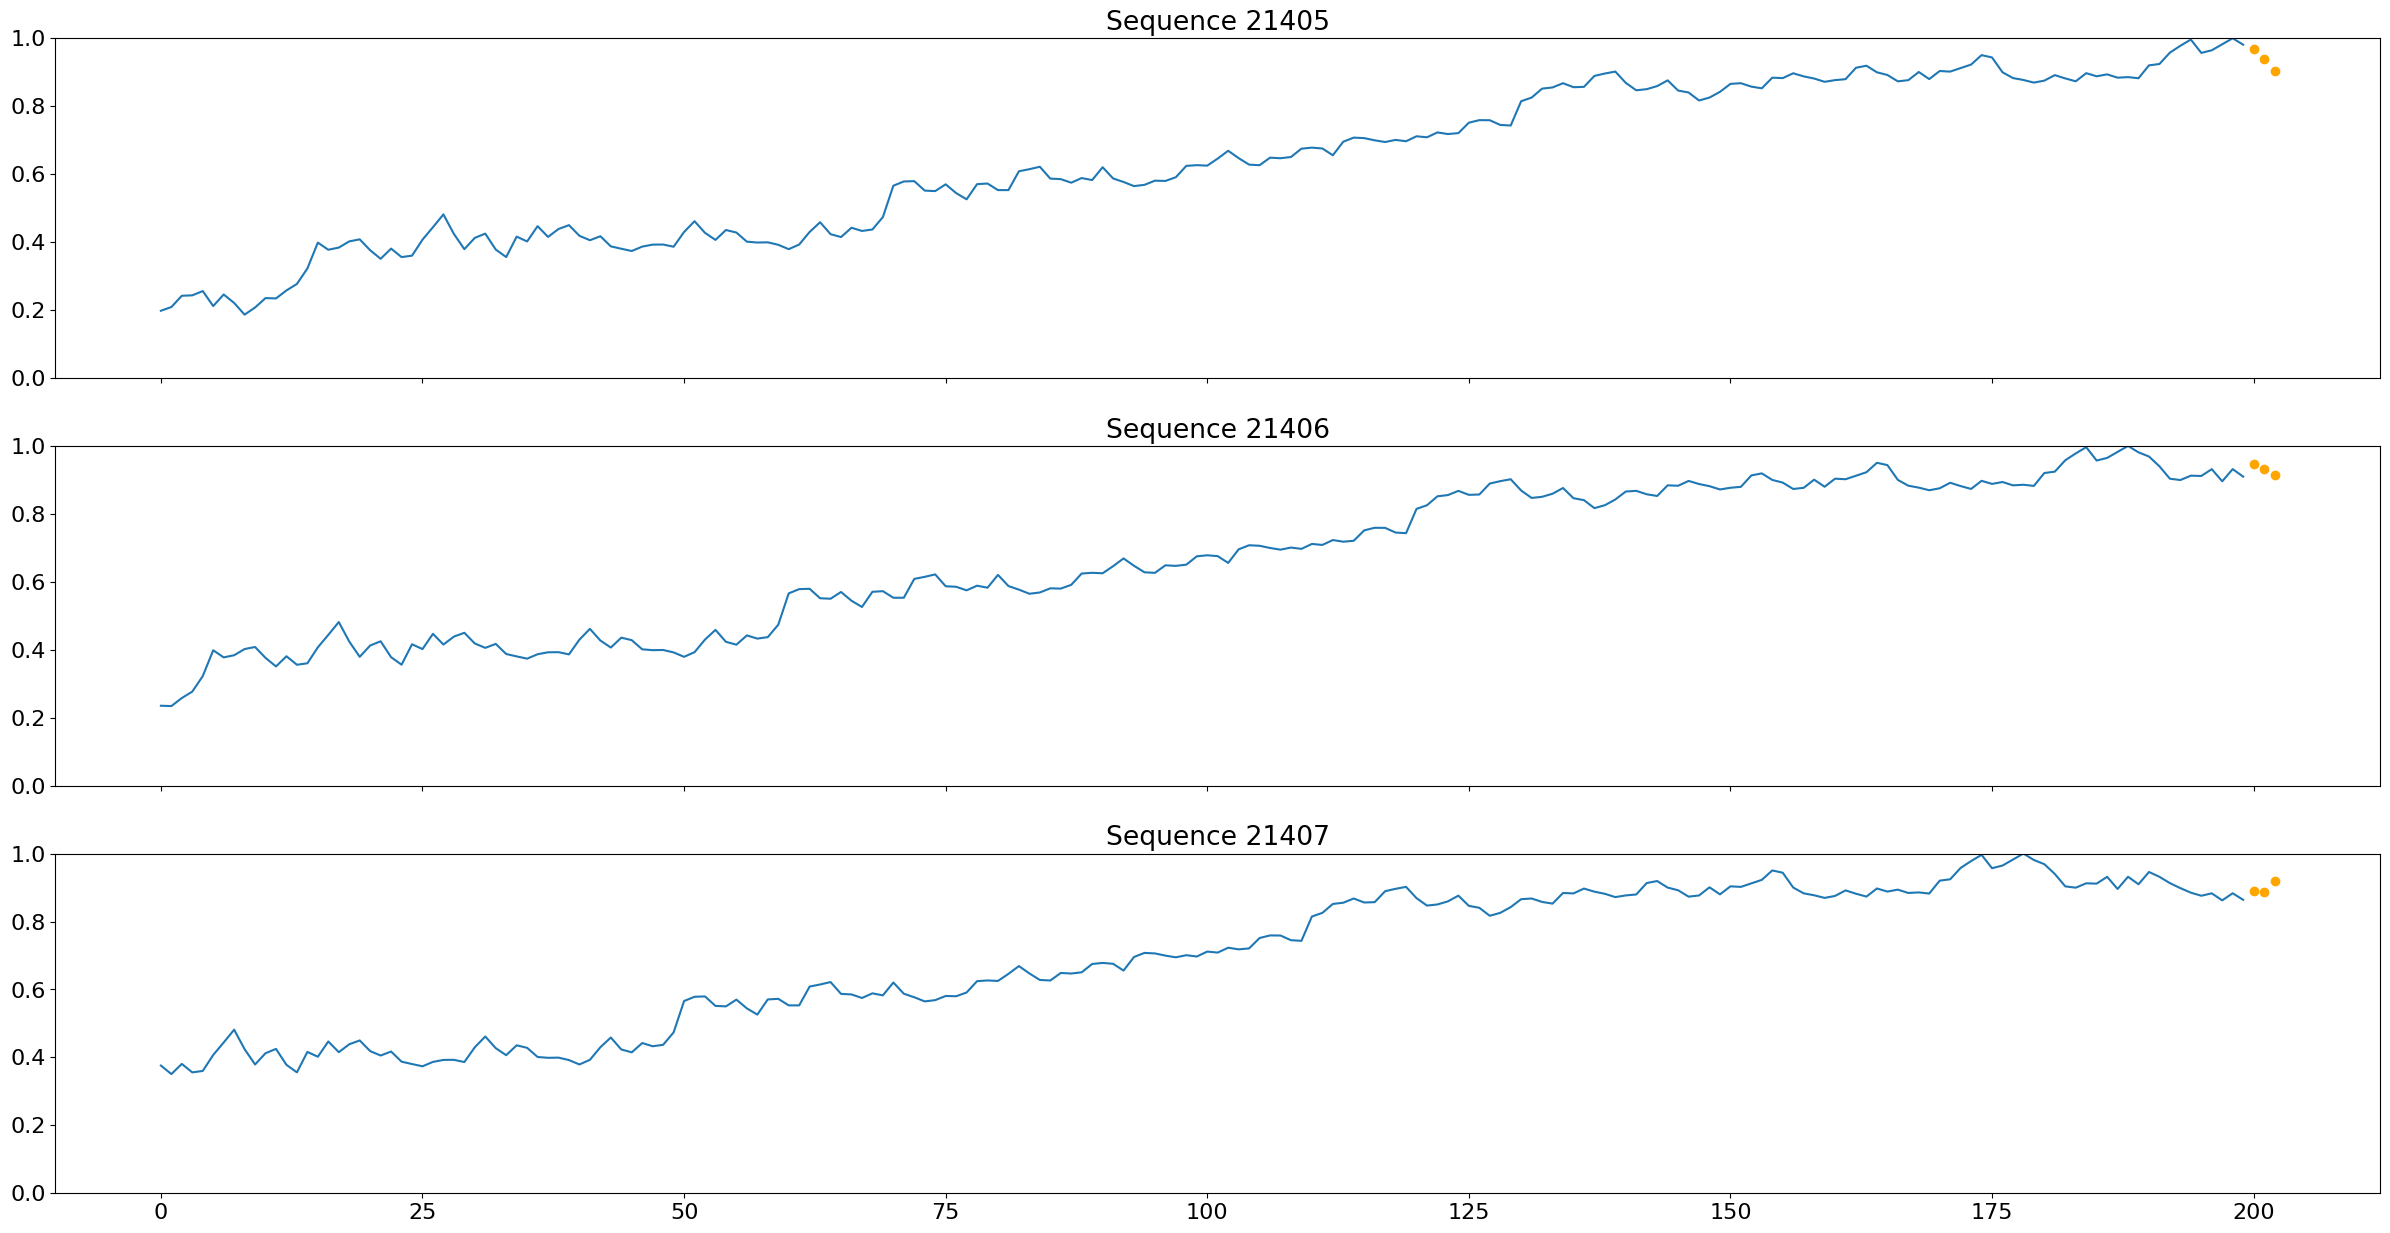

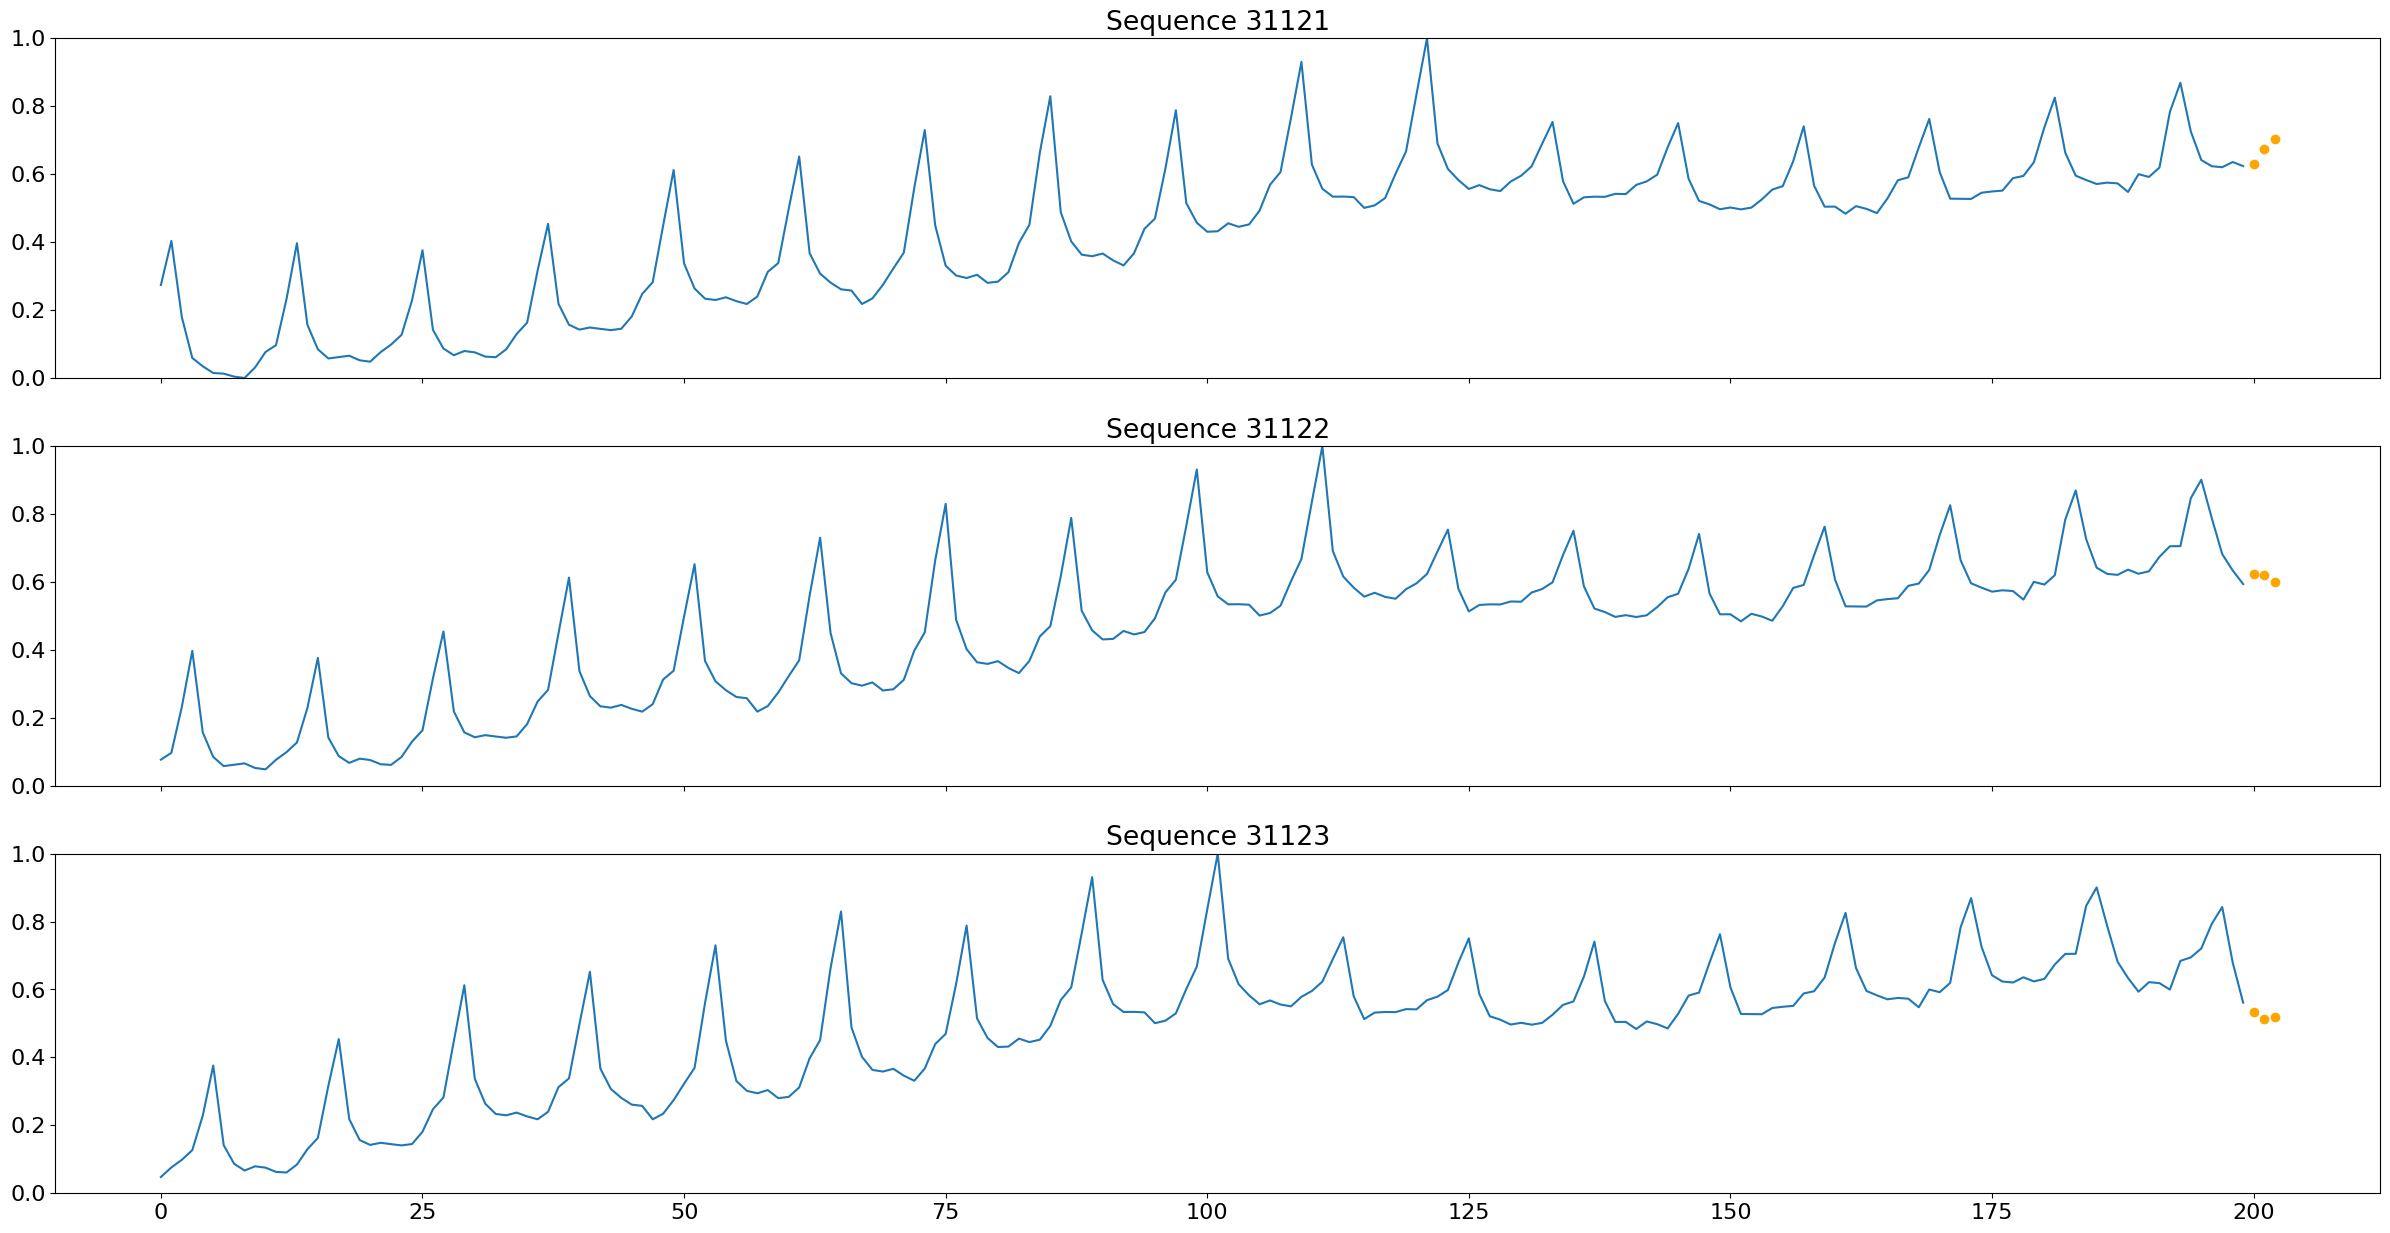

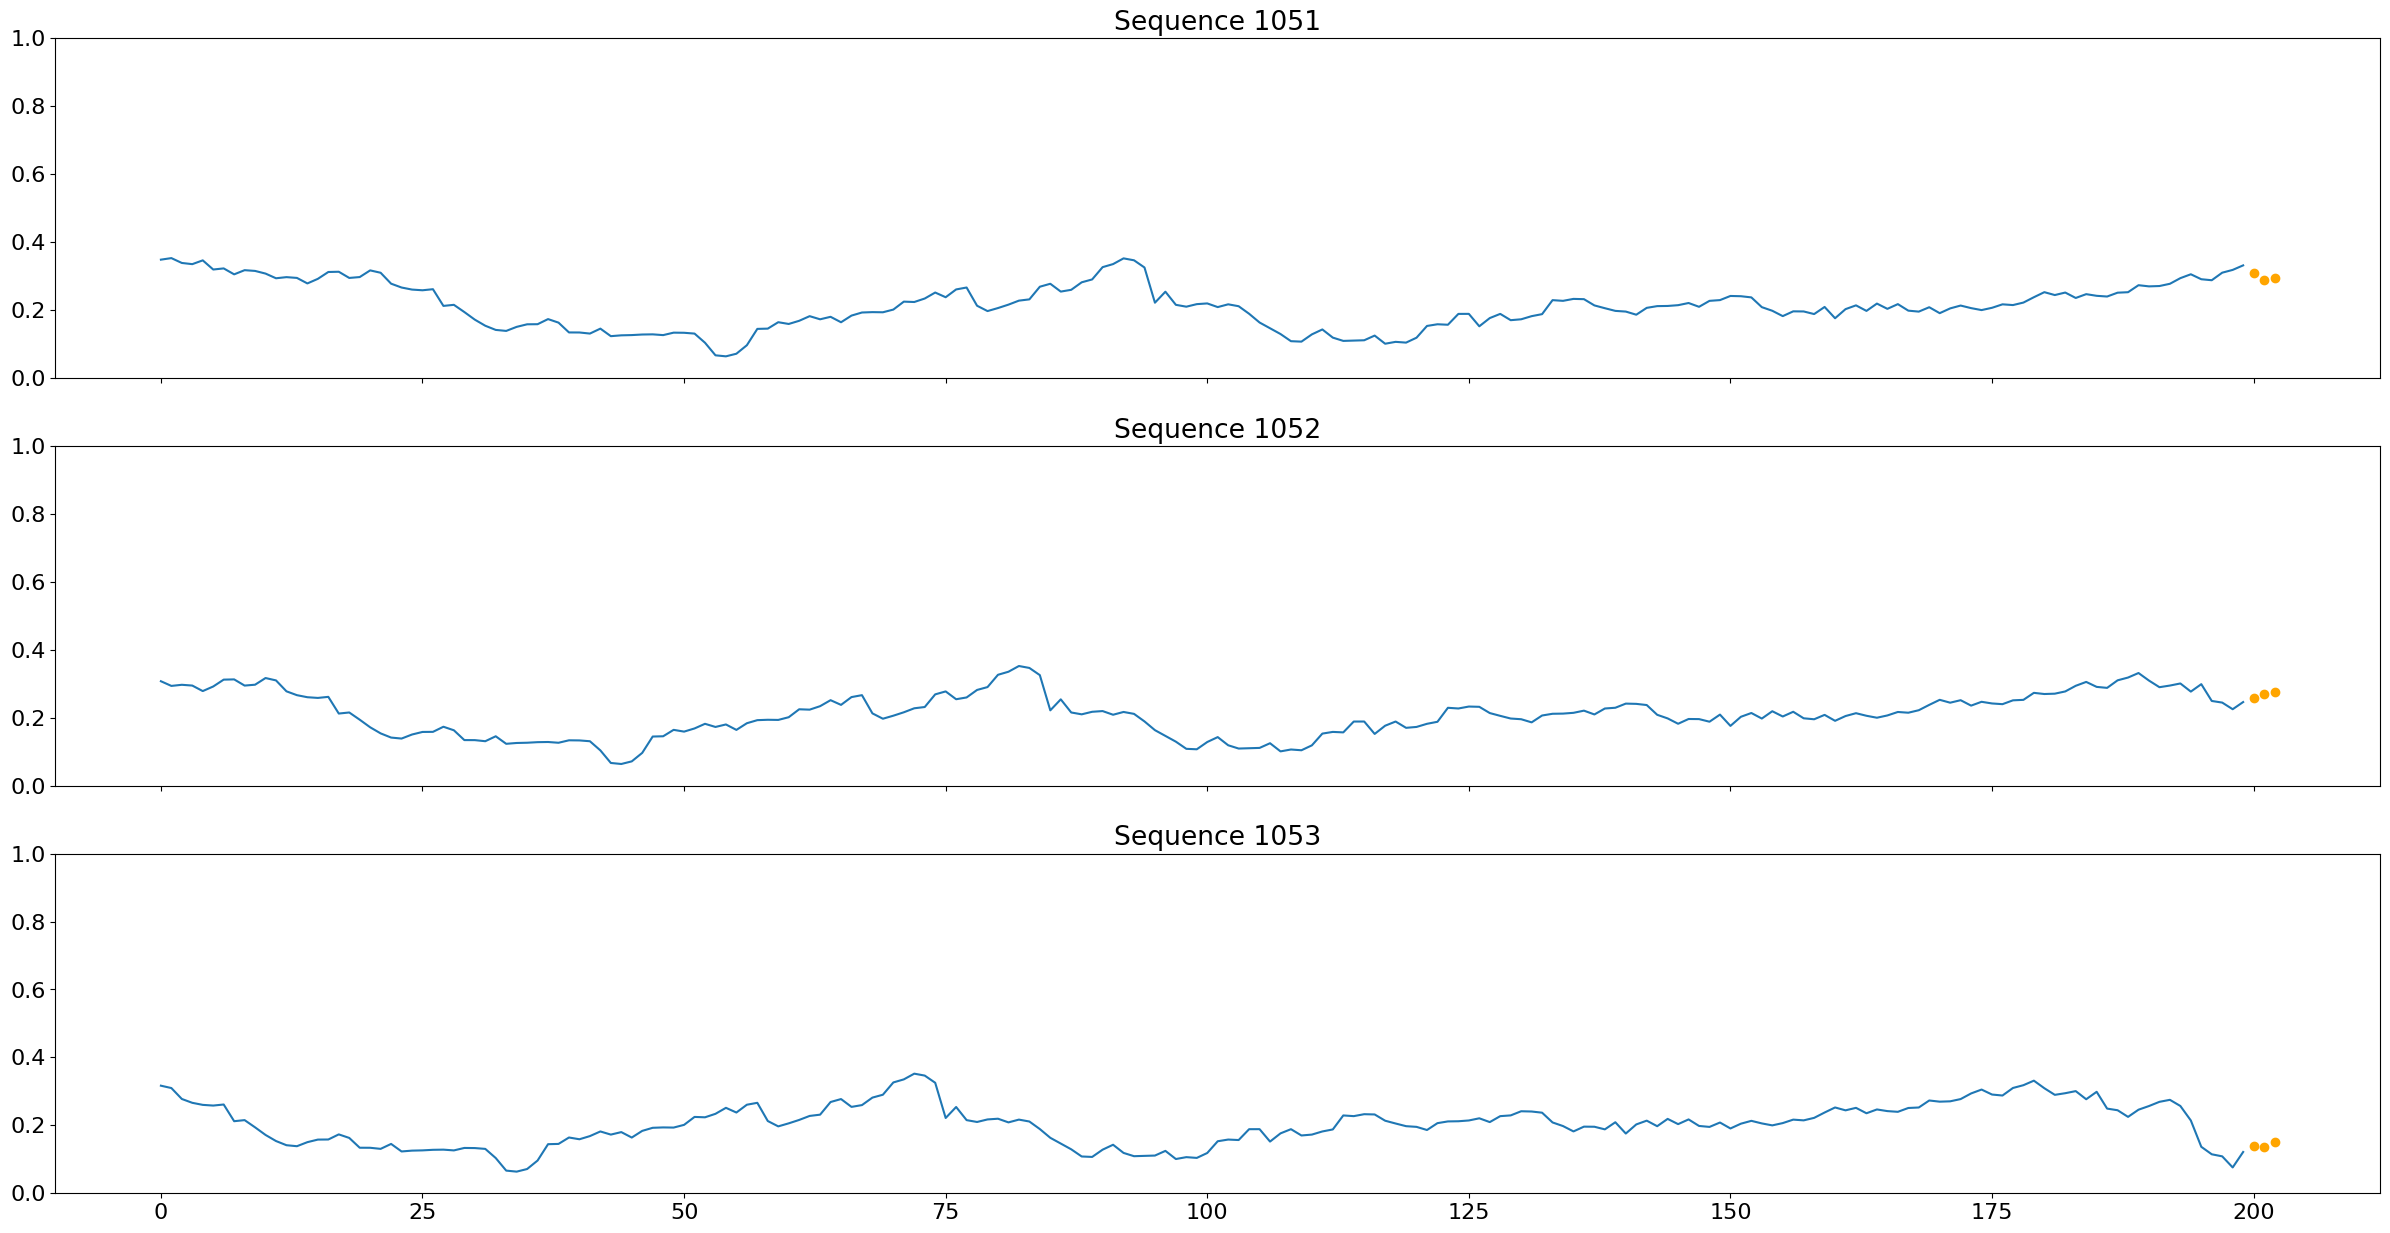

In [ ]:
# Inspect some of the sequences
for domain in range(6):
    inspect_multivariate(X_train[domain], y_train[domain], AUTOREGRESSIVE_TELESCOPE, data_to_plot=3)

In [ ]:

# -----------------------------------* FORECASTING MODEL DEFINITION *---------------------------------------

def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 32 filters and a kernel size of 3
    x = tfkl.Conv1D(32, 3, padding='same', activation='relu', name='conv1')(x)

    # Add a AveragePooling1D layer
    x = tfkl.AveragePooling1D(name='AvePool_1')(x)

    # Add a 1D Convolution layer with 64 filters and a kernel size of 5
    x = tfkl.Conv1D(64, 5, padding='same', activation='relu', name='conv2')(x)

    # Add a AveragePooling1D layer
    x = tfkl.AveragePooling1D(name='AvePool_2')(x)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 7
    x = tfkl.Conv1D(128, 7, padding='same', activation='relu', name='conv3')(x)

    # Add a AveragePooling1Dg layer
    x = tfkl.AveragePooling1D(name='AvePool_3')(x)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 7
    x = tfkl.Conv1D(256, 7, padding='same', activation='relu', name='conv4')(x)

    # Add a AveragePooling1Dg layer
    x = tfkl.AveragePooling1D(name='AvePool_4')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(1, 11, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='LSTM_CONV_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model



def build_FC_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define number of heads
    nheads = 1
    d_model = 256

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Define the first dense layers, with 256 neurons and relu activation
    x = tfkl.Dense(256)(input_layer)

    x = tfkl.BatchNormalization()(x)

    x = tfkl.Activation(activation = 'gelu')(x)

    # Second dense layer, with 128 neurons and relu activation
    x = tfkl.Dense(128)(x)

    x = tfkl.BatchNormalization()(x)

    x = tfkl.Activation(activation = 'gelu')(x)

    x = tfkl.Dropout(0.3)(x)

    # Third dense layer, with 64 neurons and relu activation
    x = tfkl.Dense(64, activation='gelu')(x)

    x = tfkl.Dropout(0.2)(x)

    # Fourth dense layer, with 32 neurons and relu activation
    x = tfkl.Dense(32, activation='gelu')(x)

    x = tfkl.Dropout(0.1)(x)

    # Output
    output_layer = tfkl.Dense(3, activation='sigmoid')(x)

    x = tfkl.Dropout(0.1)(x)

    output_layer = tfkl.Reshape(output_shape)(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='FullyConnectedForecasting_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(0.0001))

    return model



# -----------------------------------* LR SCHEDULER  *---------------------------------------


def lr_warmup_cosine_decay(global_step,
                           warmup_steps,
                           hold = 0,
                           total_steps=0,
                           start_lr=0.0,
                           target_lr=1e-3):
    # Cosine decay
    learning_rate = 0.5 * target_lr * (1 + np.cos(np.pi * (global_step - warmup_steps - hold) / float(total_steps - warmup_steps - hold)))

    # Target LR * progress of warmup (=1 at the final warmup step)
    warmup_lr = target_lr * (global_step / warmup_steps)

    # Choose between `warmup_lr`, `target_lr` and `learning_rate` based on whether `global_step < warmup_steps` and we're still holding.
    # i.e. warm up if we're still warming up and use cosine decayed lr otherwise
    if hold > 0:
        learning_rate = np.where(global_step > warmup_steps + hold,
                                 learning_rate, target_lr)

    learning_rate = np.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate

# Define callback for learning rate scheduler and warmup

class WarmupCosineDecay(tfk.callbacks.Callback):
    def __init__(self, total_steps=0, warmup_steps=0, start_lr=0.0, target_lr=1e-3, hold=0, domain = 0):

        super(WarmupCosineDecay, self).__init__()
        self.start_lr = start_lr
        self.hold = hold
        self.total_steps = total_steps
        self.global_step = 0
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.lrs = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = models[i].optimizer.lr.numpy()
        self.lrs.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = lr_warmup_cosine_decay(global_step=self.global_step,
                                    total_steps=self.total_steps,
                                    warmup_steps=self.warmup_steps,
                                    start_lr=self.start_lr,
                                    target_lr=self.target_lr,
                                    hold=self.hold)
        tfk.backend.set_value(self.model.optimizer.lr, lr)



total_steps = len(X_train[i])/BATCH_SIZE[i] *EPOCHS[i]

warmup_steps = int(0.05*total_steps)


# Print learning rate on tensorboard: write appropriate callback

class LRTensorBoard(TensorBoard):
    # add other arguments to __init__ if you need
    def __init__(self, log_dir, **kwargs):
        super().__init__(log_dir=log_dir, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super().on_epoch_end(epoch, logs)

Model: "FullyConnectedForecasting_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 256)               51456     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                  

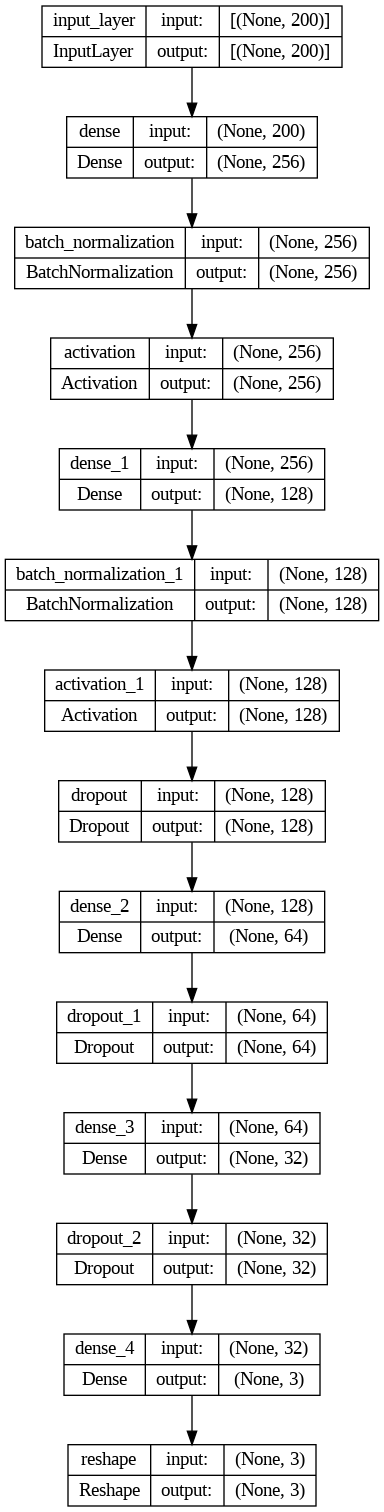

In [ ]:
# Generate the models for the different domains
models = []
for domain in range(6):
  if fully_connected:
    models.append(build_FC_model(input_shape=(WINDOW_SIZE,), output_shape=(AUTOREGRESSIVE_TELESCOPE,)))
  else:
    models.append(build_CONV_LSTM_model(input_shape=(WINDOW_SIZE, 1), output_shape=(AUTOREGRESSIVE_TELESCOPE, 1)))

# Print the summary and structure of the first model
models[0].summary()
tfk.utils.plot_model(models[0], expand_nested=True, show_shapes=True)

In [ ]:
# Train the models
for i in range(6):
    batch_size = BATCH_SIZE[i]
    epochs = EPOCHS[i]
    history = models[i].fit(
        x = X_train[i],
        y = y_train[i],
        batch_size = batch_size,
        epochs = epochs,
        validation_data=(X_val[i], y_val[i]),
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_loss', min_delta = DELTA_MIN[i],mode='min', patience=12, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5),
            #WarmupCosineDecay(total_steps=total_steps*(5/2), warmup_steps=warmup_steps,hold=total_steps*(1/3),start_lr=0.0, target_lr=1e-3, domain = i)
        ]
        # Here no class_weight is used, as the data is already belonging to the same domain
    ).history

Epoch 1/90
155/155 [==============================] - 11s 10ms/step - loss: 0.0285 - val_loss: 0.0255 - lr: 1.0000e-04
Epoch 2/90
155/155 [==============================] - 1s 7ms/step - loss: 0.0140 - val_loss: 0.0109 - lr: 1.0000e-04
Epoch 3/90
155/155 [==============================] - 1s 7ms/step - loss: 0.0115 - val_loss: 0.0066 - lr: 1.0000e-04
Epoch 4/90
155/155 [==============================] - 1s 6ms/step - loss: 0.0103 - val_loss: 0.0061 - lr: 1.0000e-04
Epoch 5/90
155/155 [==============================] - 1s 7ms/step - loss: 0.0094 - val_loss: 0.0056 - lr: 1.0000e-04
Epoch 6/90
155/155 [==============================] - 1s 6ms/step - loss: 0.0087 - val_loss: 0.0053 - lr: 1.0000e-04
Epoch 7/90
155/155 [==============================] - 1s 7ms/step - loss: 0.0082 - val_loss: 0.0052 - lr: 1.0000e-04
Epoch 8/90
155/155 [==============================] - 1s 7ms/step - loss: 0.0078 - val_loss: 0.0050 - lr: 1.0000e-04
Epoch 9/90
155/155 [==============================] - 1s 9ms/s

In [ ]:
# Save the models
for i in range(6):
    models[i].save('Fourth_Attempt/secondTry/model_{}'.format(i))

In [ ]:
# And delete them from memory
del models

In [ ]:
# Load pretrained models
models = []
for i in range(6):
    models.append(tfk.models.load_model('Fourth_Attempt/secondTry/model_{}'.format(i)))
# and rename them
for i in range(6):
    models[i]._name = 'model_{}'.format(i)


In [ ]:
# -----------------------------------* ENSEMBLE MODEL DEFINITION *---------------------------------------

# Generate the ensemble model: the models all take as input the same sequences, that are the domain specific ones concatenated
# and their predictions are the concatenated and given as input to a final dense layer, that is a voting layer
def build_ensemble_model(models):
    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=(WINDOW_SIZE, 1), name='input_layer')

    # Define a list to store the outputs of the models
    outputs = []

    # Loop over the models
    for i in range(len(models)):
        # Append the output of the current model to the list of outputs
        models[i].trainable = False
        outputs.append(models[i](input_layer))

    # Concatenate all the outputs
    x = tfkl.Concatenate(name='concatenate')(outputs)

    # Add a Dense layer with 64 units and relu activation
    voter = tfkl.Dense(64, activation='gelu', name='voter0')(x)

    # Dropout
    voter = tfkl.Dropout(0.2)(voter)

    # Add a Dense layer with 128 units and relu activation
    voter = tfkl.Dense(128, activation='gelu', name='voter1')(voter)

    # Dropout
    voter = tfkl.Dropout(0.2)(voter)

    # Add a Dense layer with 64 units and relu activation
    voter = tfkl.Dense(64, activation='gelu', name='voter2')(voter)

    # Dropout
    voter = tfkl.Dropout(0.1)(voter)

    # Add a final Dense layer with 1 units and a sigmoid activation
    output_layer = tfkl.Dense(3, activation='sigmoid', name='output_layer')(voter)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='ensemble_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "ensemble_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 model_0 (Functional)        (None, 3)                    96323     ['input_layer[0][0]']         
                                                                                                  
 model_1 (Functional)        (None, 3)                    96323     ['input_layer[0][0]']         
                                                                                                  
 model_2 (Functional)        (None, 3)                    96323     ['input_layer[0][0]']         
                                                                                     

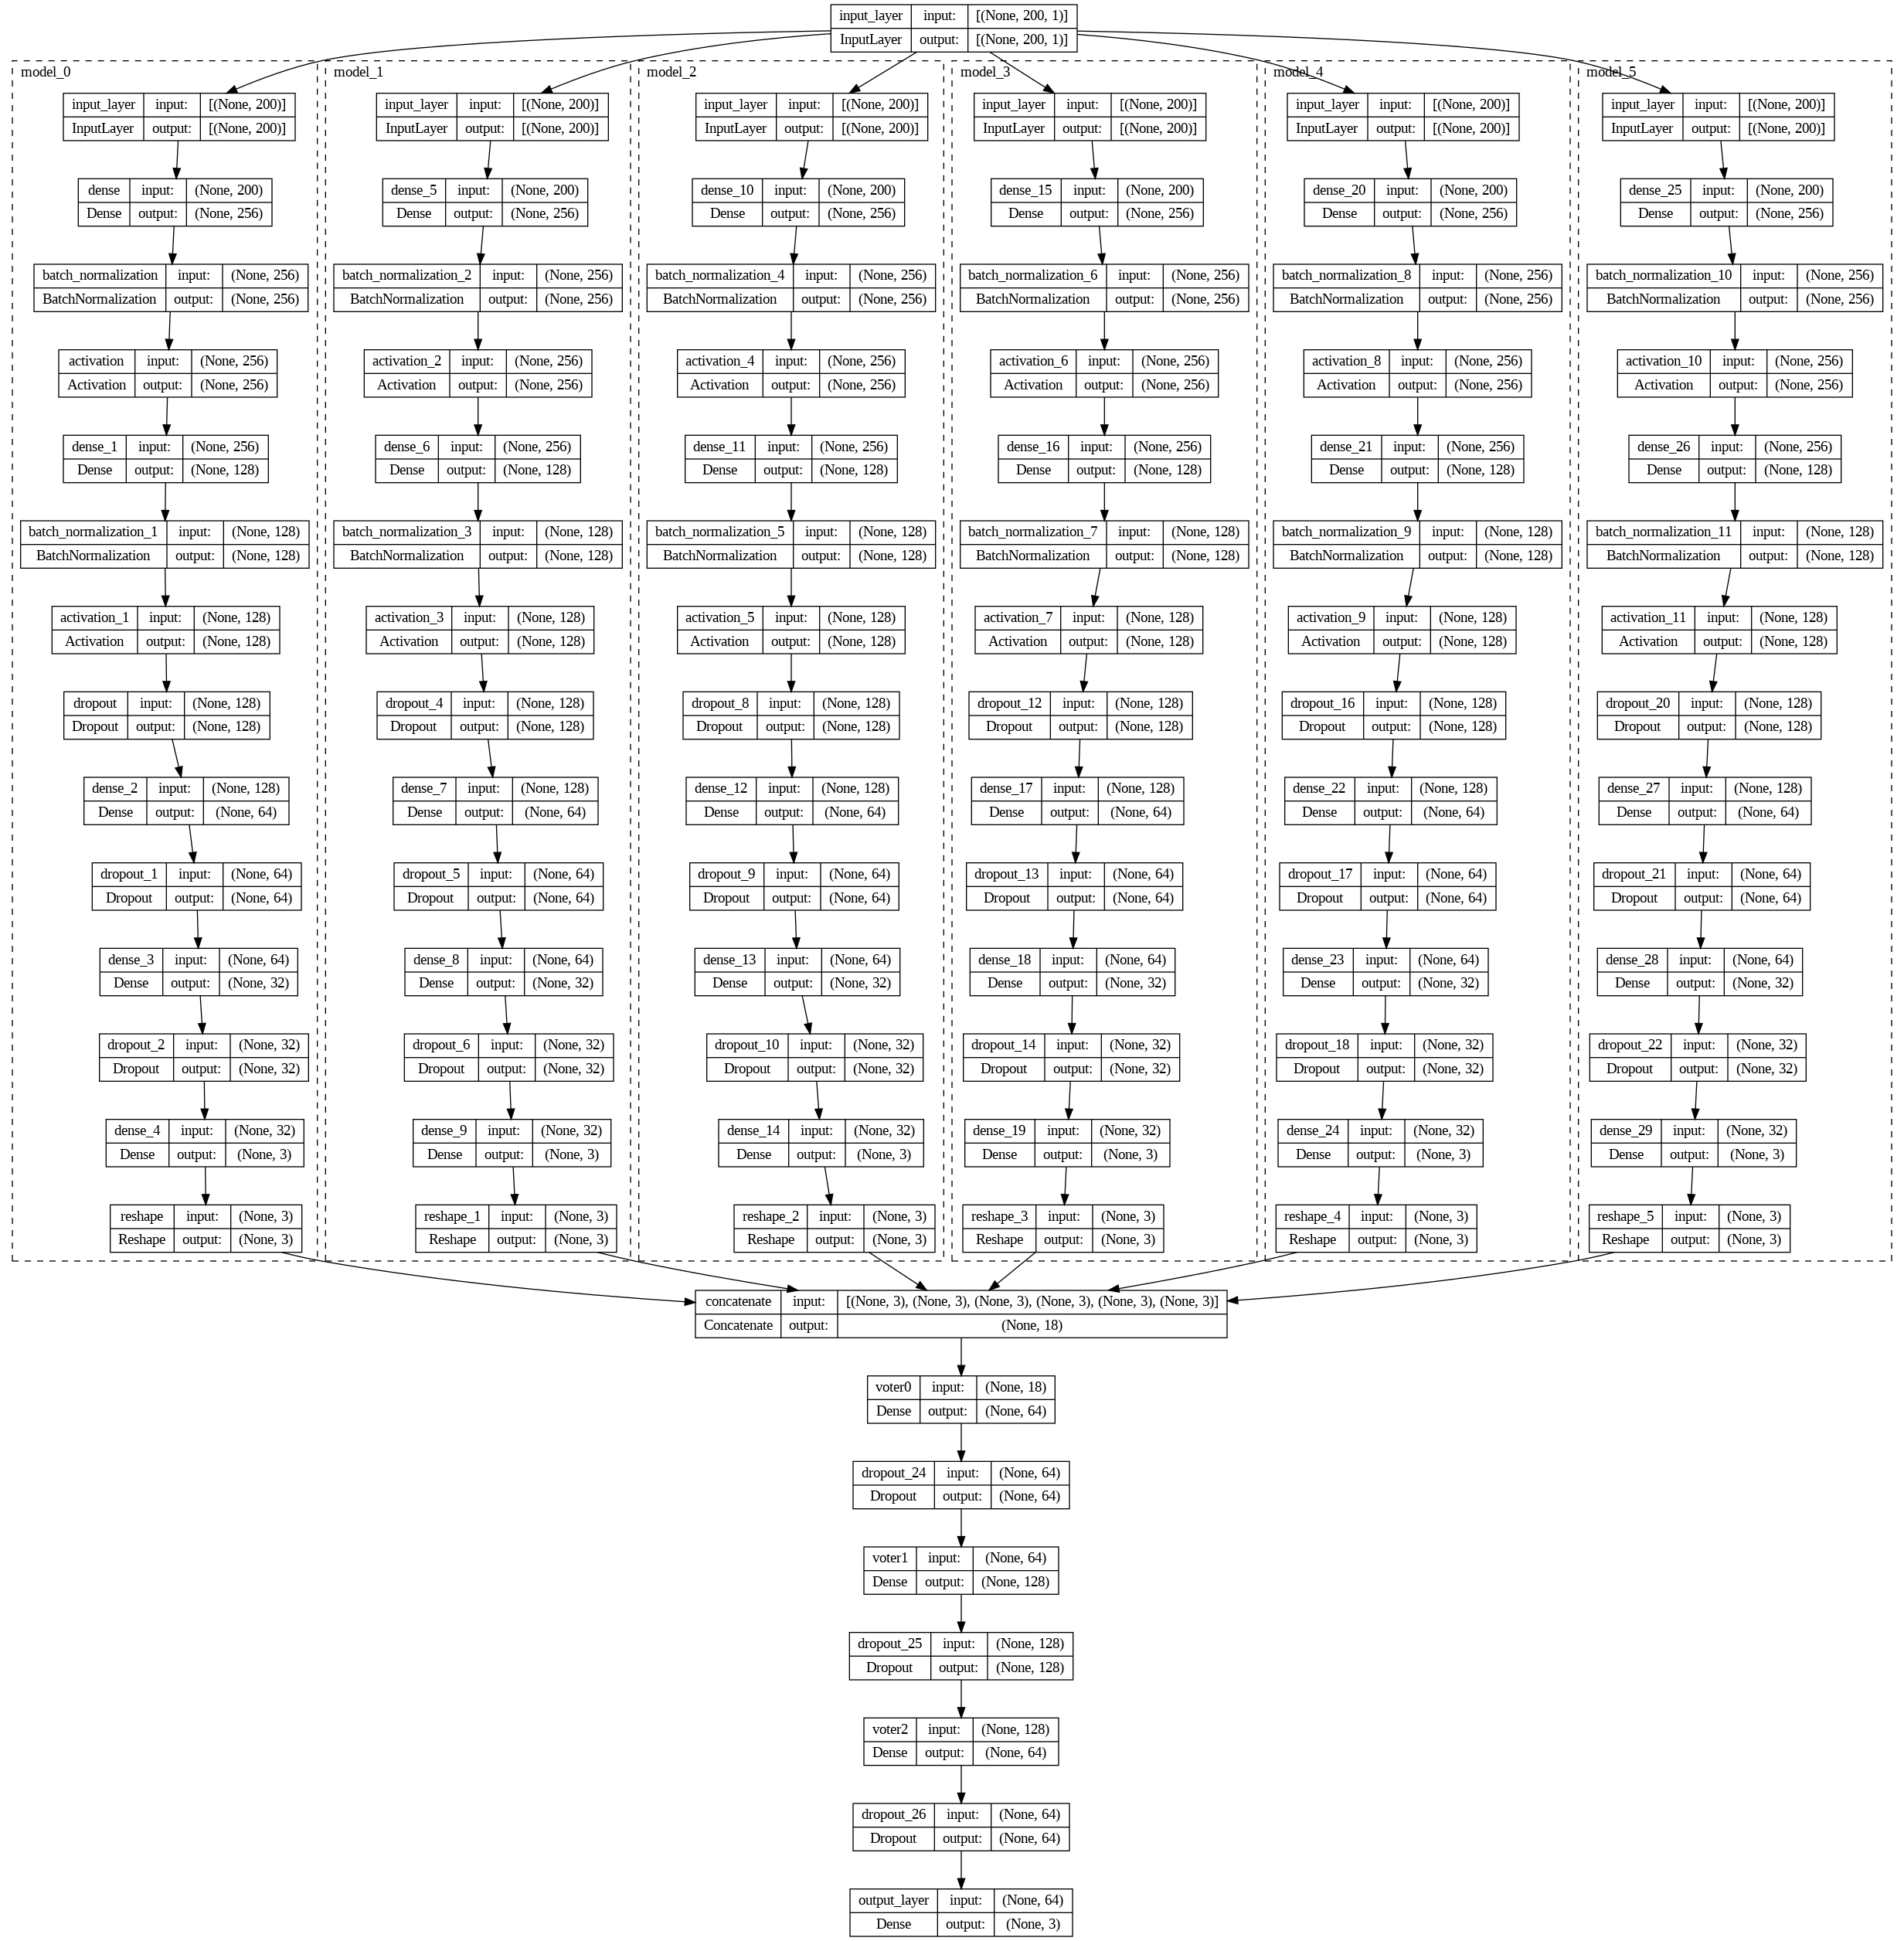

In [ ]:
# Build the ensemble model
ensemble_model = build_ensemble_model(models)
# Print the summary and structure of the ensemble model
ensemble_model.summary()
tfk.utils.plot_model(ensemble_model, expand_nested=True, show_shapes=True)

In [ ]:
# Concate the different datasets
X_train = np.concatenate(X_train)
X_val = np.concatenate(X_val)
y_train = np.concatenate(y_train)
y_val = np.concatenate(y_val)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(197919, 200)
(50767, 200)
(197919, 3)
(50767, 3)


In [ ]:

# Change the batch size to the one used for the ensemble model
batch_size = 512
epochs = 15
# Train the ensemble model
history = ensemble_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=6, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/15
387/387 [==============================] - 9s 11ms/step - loss: 0.0107 - val_loss: 0.0044 - lr: 0.0010
Epoch 2/15
387/387 [==============================] - 4s 10ms/step - loss: 0.0050 - val_loss: 0.0040 - lr: 0.0010
Epoch 3/15
387/387 [==============================] - 4s 10ms/step - loss: 0.0047 - val_loss: 0.0039 - lr: 0.0010
Epoch 4/15
387/387 [==============================] - 4s 9ms/step - loss: 0.0046 - val_loss: 0.0039 - lr: 0.0010
Epoch 5/15
387/387 [==============================] - 3s 9ms/step - loss: 0.0046 - val_loss: 0.0039 - lr: 0.0010
Epoch 6/15
387/387 [==============================] - 4s 11ms/step - loss: 0.0045 - val_loss: 0.0038 - lr: 0.0010
Epoch 7/15
387/387 [==============================] - 4s 9ms/step - loss: 0.0045 - val_loss: 0.0038 - lr: 0.0010
Epoch 8/15
387/387 [==============================] - 4s 9ms/step - loss: 0.0044 - val_loss: 0.0038 - lr: 0.0010
Epoch 9/15
387/387 [==============================] - 3s 8ms/step - loss: 0.0044 - val_loss:

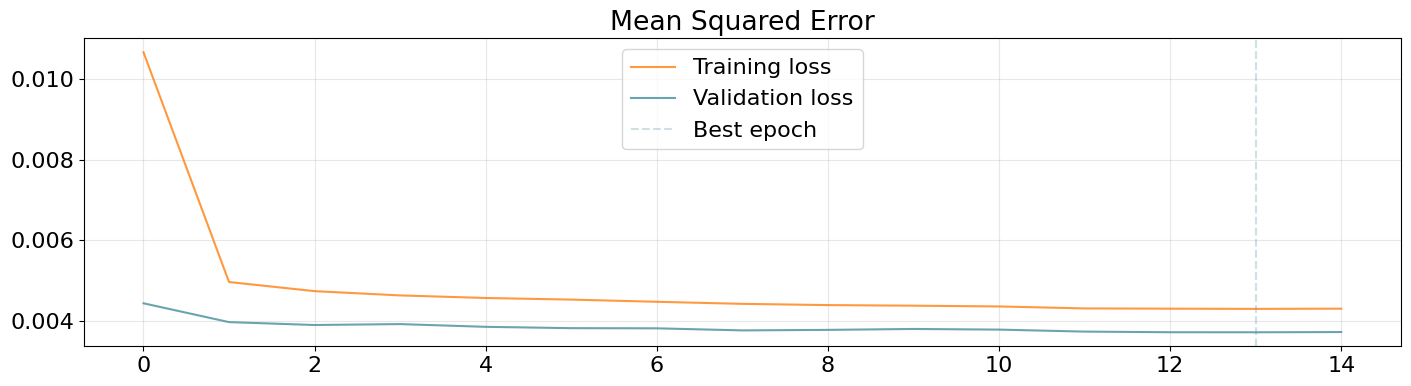

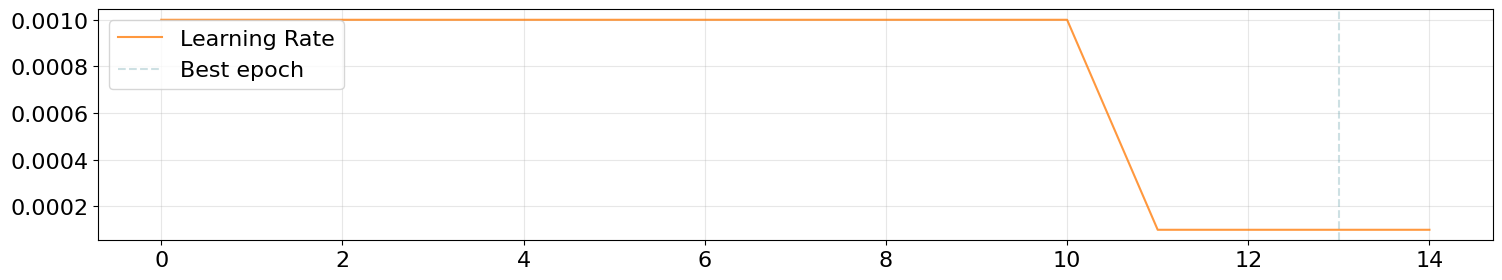

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()


ensemble_model.save("Fourth_Attempt/FourthAttempt")

In [ ]:
del ensemble_model

In [ ]:
del models

In [ ]:
model = tfk.models.load_model('Fourth_Attempt/FourthAttempt')
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,TELESCOPE,AUTOREGRESSIVE_TELESCOPE):
    pred_temp = model.predict(X_temp,verbose=0)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)

    if fully_connected:
      X_temp = np.concatenate((X_temp[:,AUTOREGRESSIVE_TELESCOPE:],pred_temp), axis=1)
    else:
      X_temp = np.concatenate((X_temp[:,AUTOREGRESSIVE_TELESCOPE:,:],pred_temp), axis=1)


In [ ]:
# Print the shape of the predictions
print(f"Predictions shape: {reg_predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test_reg.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test_reg.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (7359, 18)
Mean Squared Error: 0.008668695576488972
Mean Absolute Error: 0.06237350404262543


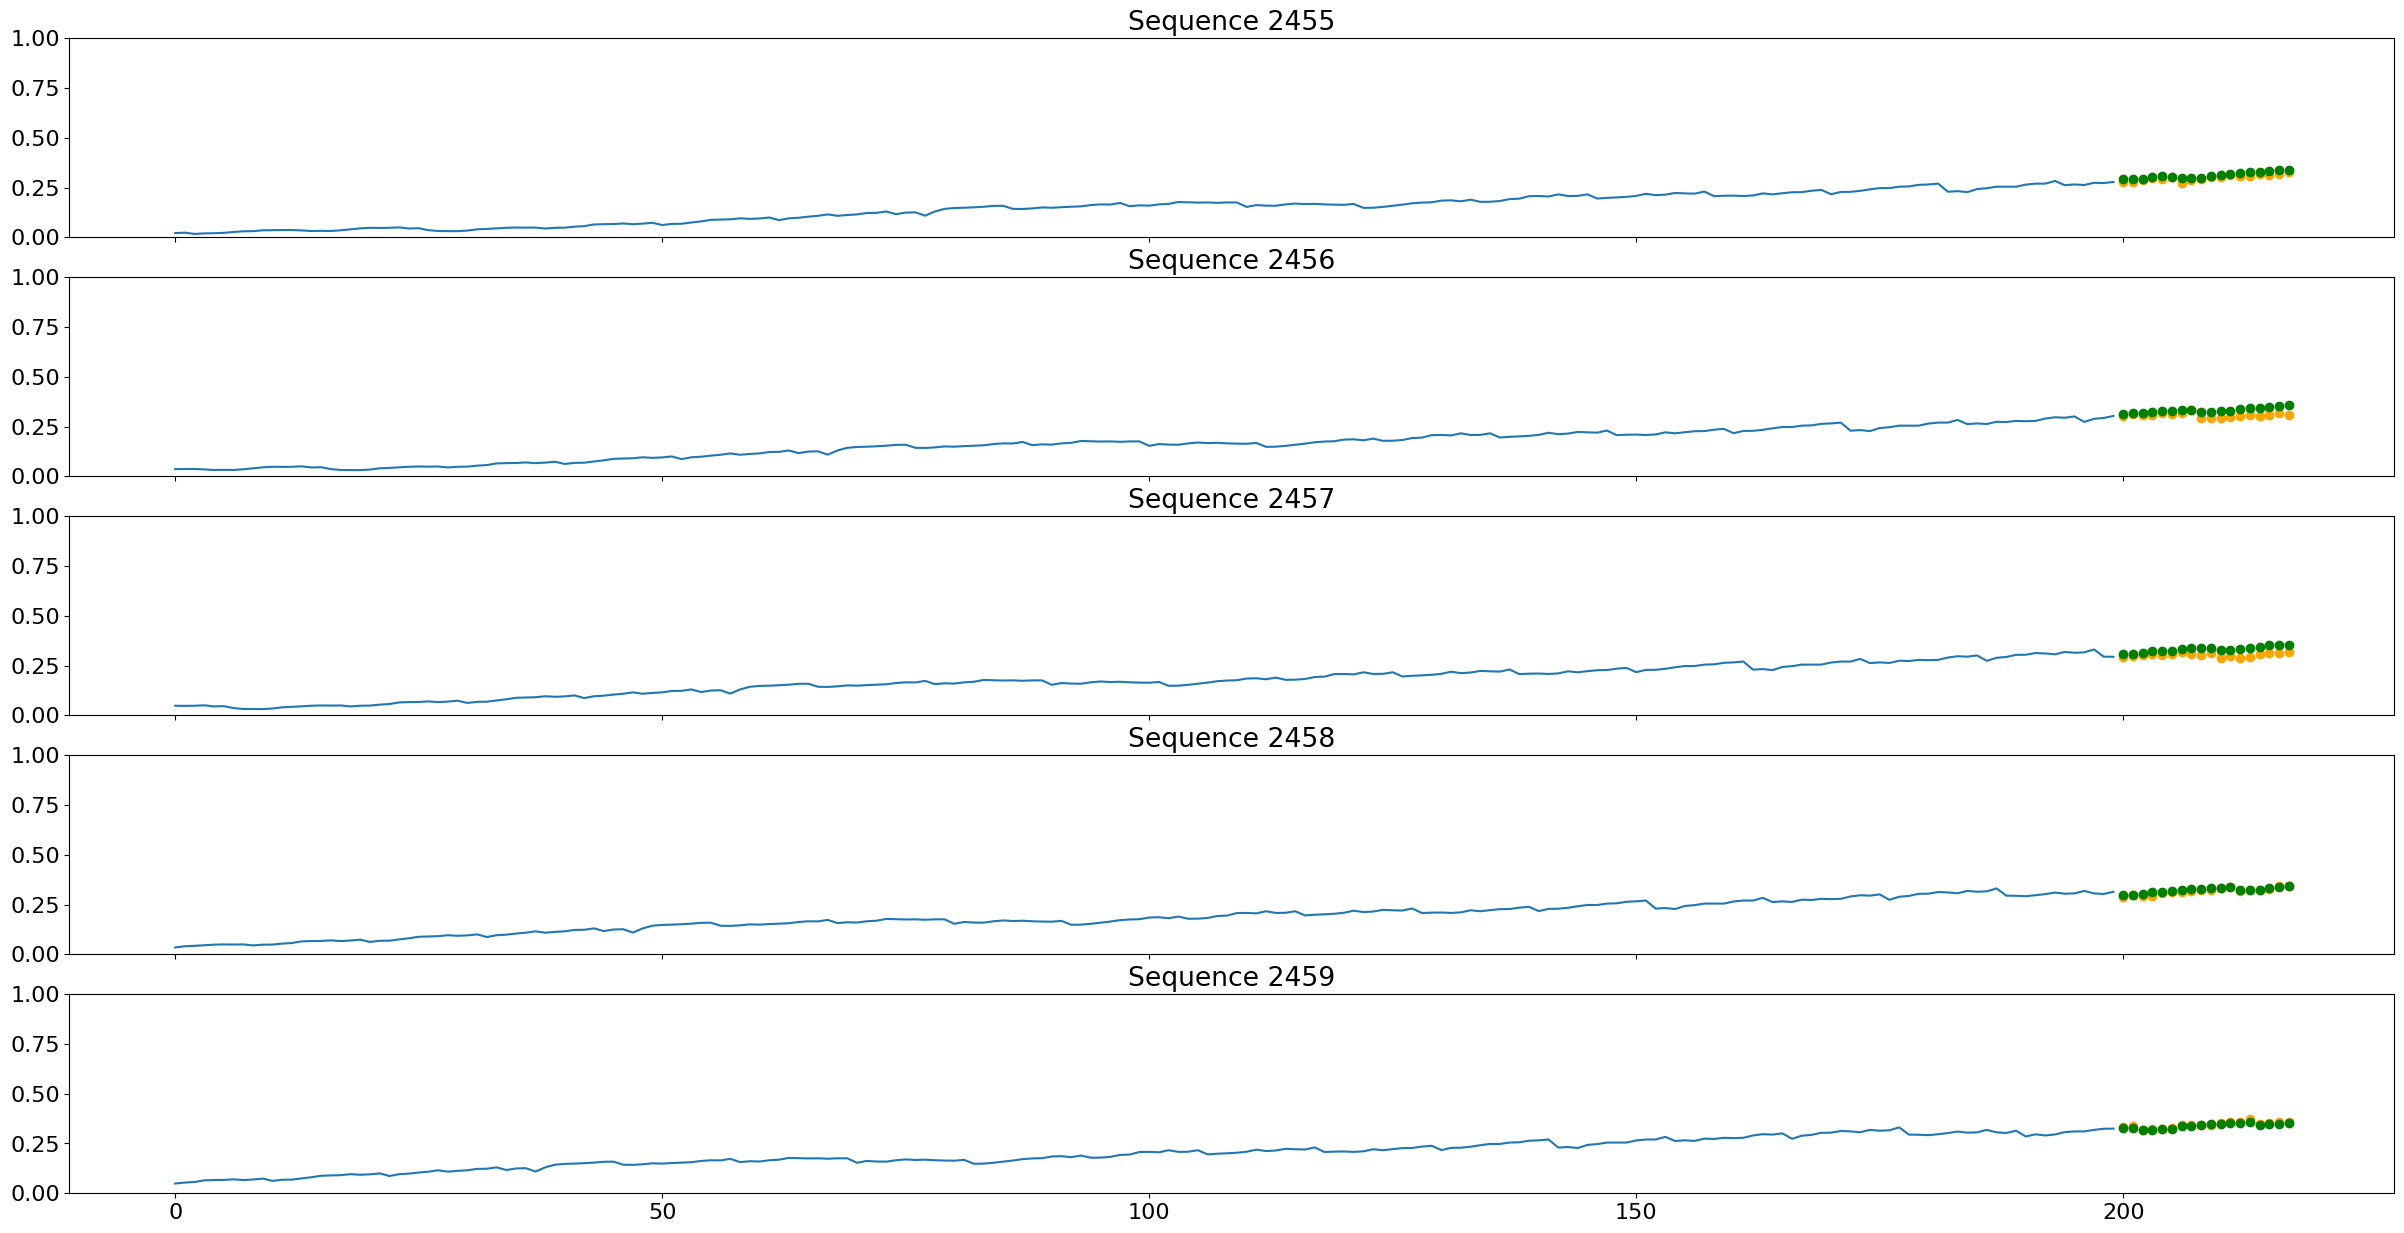

In [ ]:
inspect_multivariate_prediction(X_test_reg, y_test_reg,reg_predictions, TELESCOPE)